<a href="https://colab.research.google.com/github/nati-curious/data_science_portfolio/blob/main/time_series_statsmodels_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting the number of bikes rented per hour `cnt`**



# Libraries and Framewoorks

In [ ]:
pip install statsforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 KB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 KB 4.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 KB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.7/236.7 KB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.8/187.8 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.1/185.1 KB 12.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from pandas.plotting import lag_plot
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor

import scipy.stats as st
from sklearn.metrics import mean_absolute_error
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [ ]:
plt.rcParams["figure.figsize"] = (18, 8)

sns.set_theme()
sns.set(font_scale = 1.25)

FONT_SIZE=14

# EDA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# upload and read the dataset
df = pd.read_csv('/content/drive/MyDrive/hour.csv')
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [ ]:
# check missing values, data types, number of rows and columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [ ]:
# drop duplicates if any
df.drop_duplicates().head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [ ]:
# no duplicates
df.shape

(17379, 17)

**Variables analysis**

**instant**: record index

In [ ]:
# counts of unique values; the first element is the most frequently-occurring one
df.instant.value_counts()

1        1
11592    1
11578    1
11579    1
11580    1
        ..
5799     1
5800     1
5801     1
5802     1
17379    1
Name: instant, Length: 17379, dtype: int64

In [ ]:
# sort values from smallest to largest
# method helps to find anomalies in data
df.instant.sort_values()

0            1
1            2
2            3
3            4
4            5
         ...  
17374    17375
17375    17376
17376    17377
17377    17378
17378    17379
Name: instant, Length: 17379, dtype: int64

**dteday**: date

In [ ]:
df.dteday.value_counts()

2011-01-01    24
2012-04-03    24
2012-04-28    24
2012-04-29    24
2012-04-30    24
              ..
2011-01-26    16
2011-01-18    12
2012-10-30    11
2011-01-27     8
2012-10-29     1
Name: dteday, Length: 731, dtype: int64

In [ ]:
df.dteday.sort_values()

0        2011-01-01
23       2011-01-01
22       2011-01-01
21       2011-01-01
20       2011-01-01
            ...    
17356    2012-12-31
17355    2012-12-31
17377    2012-12-31
17365    2012-12-31
17378    2012-12-31
Name: dteday, Length: 17379, dtype: object

**season**: season (1:spring, 2:summer, 3:fall, 4:winter)

In [ ]:
df.season.value_counts()

3    4496
2    4409
1    4242
4    4232
Name: season, dtype: int64

In [ ]:
df.season.sort_values()

0       1
9199    1
9198    1
9197    1
9196    1
       ..
7666    4
7667    4
7668    4
7654    4
8007    4
Name: season, Length: 17379, dtype: int64

In [ ]:
# seasons are indicated wrong: spring is January, summer is March, fall is June, winter is November
df_season = df.groupby('season')
df_season.first()

,instant,dteday,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
season,,,,,,,,,,,,,,,,
1,1,2011-01-01,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
2,1808,2011-03-21,0,3,0,0,1,1,3,0.34,0.3030,0.66,0.3881,2,11,13
3,4011,2011-06-21,0,6,0,0,2,1,1,0.62,0.5909,0.78,0.1642,10,23,33
4,6251,2011-09-23,0,9,0,0,5,1,2,0.62,0.5455,0.94,0.0896,11,41,52


In [ ]:
# maybe it is just shift in a number and all values are grouped correct
# let's look closer
df_season = df.groupby(['season', 'mnth'])
df_season.first()

instant      dteday  yr  hr  holiday  weekday  workingday  \
season mnth                                                              
1      1           1  2011-01-01   0   0        0        6           0   
       2         689  2011-02-01   0   0        0        2           1   
       3        1338  2011-03-01   0   0        0        2           1   
       12       8385  2011-12-21   0   0        0        3           1   
2      3        1808  2011-03-21   0   0        0        1           1   
       4        2068  2011-04-01   0   0        0        5           1   
       5        2787  2011-05-01   0   0        0        0           0   
       6        3531  2011-06-01   0   0        0        3           1   
3      6        4011  2011-06-21   0   0        0        2           1   
       7        4251  2011-07-01   0   0        0        5           1   
       8        4995  2011-08-01   0   0        0        1           1   
       9        5726  2011-09-01   0   0        0        4           1   
4      9        6251  2011-09-23   0   0        0        5           1   
       10       6443  2011-10-01   0   0        0        6           0   
       11       7186  2011-11-01   0   0        0        2           1   
       12       7905  2011-12-01   0   0        0        4           1   

             weathersit  temp   atemp   hum  windspeed  casual  registered  \
season mnth                                                                  
1      1              1  0.24  0.2879  0.81     0.0000       3          13   
       2              2  0.16  0.1818  0.64     0.1045       2           6   
       3              1  0.30  0.2727  0.70     0.4627       0           7   
       12             2  0.34  0.3333  0.71     0.1343       7          18   
2      3              3  0.34  0.3030  0.66     0.3881       2          11   
       4              3  0.26  0.2576  1.00     0.1642       0           6   
       5              1  0.42  0.4242  0.67     0.0896      19          77   
       6              1  0.70  0.6667  0.79     0.1642       9          25   
3      6              1  0.62  0.5909  0.78     0.1642      10          23   
       7              1  0.66  0.6212  0.50     0.0000      20          48   
       8              1  0.72  0.6818  0.70     0.2239       7          22   
       9              1  0.60  0.5758  0.78     0.1045      18          33   
4      9              2  0.62  0.5455  0.94     0.0896      11          41   
       10             1  0.50  0.4848  0.63     0.3881      24         106   
       11             2  0.36  0.3485  0.87     0.1642       3          18   
       12             1  0.28  0.2576  0.52     0.3284       1          19   

             cnt  
season mnth       
1      1      16  
       2       8  
       3       7  
       12     25  
2      3      13  
       4       6  
       5      96  
       6      34  
3      6      33  
       7      68  
       8      29  
       9      51  
4      9      52  
       10    130  
       11     21  
       12     20

In [ ]:
# not only numbers of season are shifted;
# at the junctions of the seasons there are months that belong to two seasons at the same time
fig = px.scatter(df, x="mnth", y="season", hover_data=['dteday'])
fig.show()

**yr** - year (0: 2011, 1:2012)

In [ ]:
df.yr.value_counts()

1    8734
0    8645
Name: yr, dtype: int64

In [ ]:
df.yr.sort_values()

0        0
5772     0
5771     0
5770     0
5769     0
        ..
11556    1
11557    1
11558    1
11552    1
17378    1
Name: yr, Length: 17379, dtype: int64

**mnth** - month ( 1 to 12)

In [ ]:
df.mnth.value_counts()

5     1488
7     1488
12    1483
8     1475
3     1473
10    1451
6     1440
4     1437
9     1437
11    1437
1     1429
2     1341
Name: mnth, dtype: int64

In [ ]:
df.mnth.sort_values()

0         1
8898      1
8897      1
8896      1
8895      1
         ..
8395     12
8394     12
8393     12
8402     12
17378    12
Name: mnth, Length: 17379, dtype: int64

In [ ]:
# check if months matches date
df_month = df.groupby(['mnth', 'dteday'])
df_month.first()

instant  season  yr  hr  holiday  weekday  workingday  \
mnth dteday                                                              
1    2011-01-01        1       1   0   0        0        6           0   
     2011-01-02       25       1   0   0        0        0           0   
     2011-01-03       48       1   0   0        0        1           1   
     2011-01-04       70       1   0   0        0        2           1   
     2011-01-05       93       1   0   0        0        3           1   
...                  ...     ...  ..  ..      ...      ...         ...   
12   2012-12-27    17260       1   1   0        0        4           1   
     2012-12-28    17284       1   1   0        0        5           1   
     2012-12-29    17308       1   1   0        0        6           0   
     2012-12-30    17332       1   1   0        0        0           0   
     2012-12-31    17356       1   1   0        0        1           1   

                 weathersit  temp   atemp   hum  windspeed  casual  \
mnth dteday                                                          
1    2011-01-01           1  0.24  0.2879  0.81     0.0000       3   
     2011-01-02           2  0.46  0.4545  0.88     0.2985       4   
     2011-01-03           1  0.22  0.1970  0.44     0.3582       0   
     2011-01-04           1  0.16  0.1818  0.55     0.1045       0   
     2011-01-05           1  0.20  0.2576  0.64     0.0000       0   
...                     ...   ...     ...   ...        ...     ...   
12   2012-12-27           3  0.26  0.2273  0.87     0.2985       0   
     2012-12-28           2  0.24  0.2424  0.60     0.1642       3   
     2012-12-29           2  0.24  0.2424  0.70     0.0000       1   
     2012-12-30           2  0.26  0.2576  0.60     0.1642       0   
     2012-12-31           1  0.18  0.1818  0.55     0.1940       4   

                 registered  cnt  
mnth dteday                       
1    2011-01-01          13   16  
     2011-01-02          13   17  
     2011-01-03           5    5  
     2011-01-04           5    5  
     2011-01-05           6    6  
...                     ...  ...  
12   2012-12-27           3    3  
     2012-12-28          22   25  
     2012-12-29          25   26  
     2012-12-30          41   41  
     2012-12-31          30   34  

[731 rows x 15 columns]

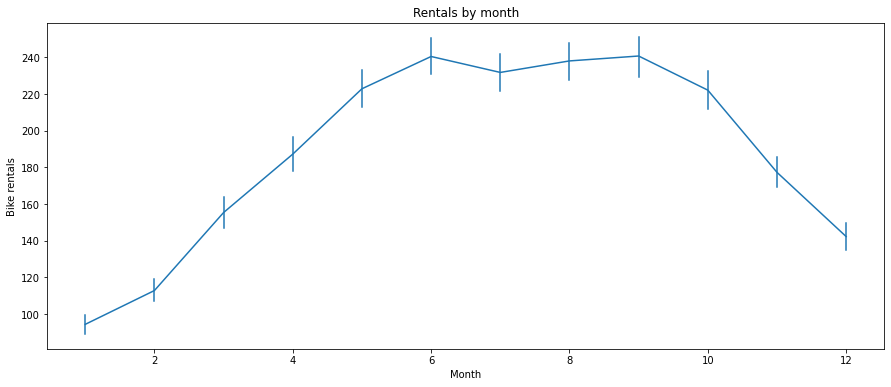

In [ ]:
# lineplot of bike demand during the year
plt.figure(figsize=(15,6))
sns.lineplot(data=df, x="mnth", y="cnt", err_style="bars").set(
    title="Rentals by month",
    xlabel="Month",
    ylabel="Bike rentals"
    );

The highest demand for bikes is in June, August, and September. The lowest demand is in December, January, and February. It is quite obvious that people prefer to bike when it is warm weather. But not hot! July is not among the months when people like biking probably because of high temperature. Let's check our assumption by plotting a graph of temperature and feeling temperature during the year.

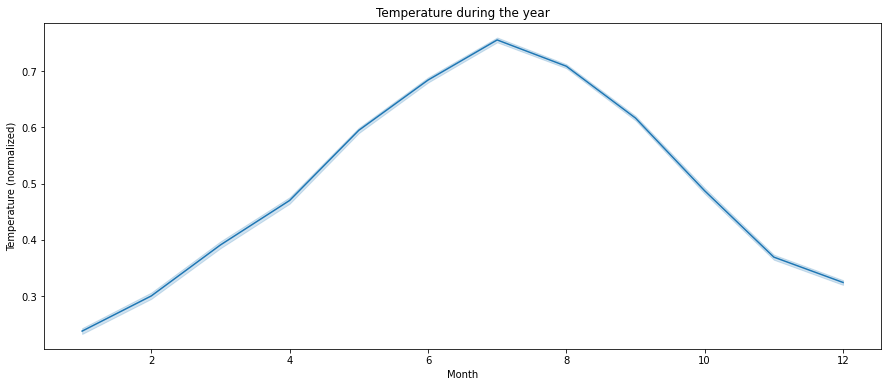

In [ ]:
# graph of temperature during the year
plt.figure(figsize=(15,6))
sns.lineplot(data=df, x="mnth", y="temp").set(
    title="Temperature during the year",
    xlabel="Month",
    ylabel="Temperature (normalized)"
    );

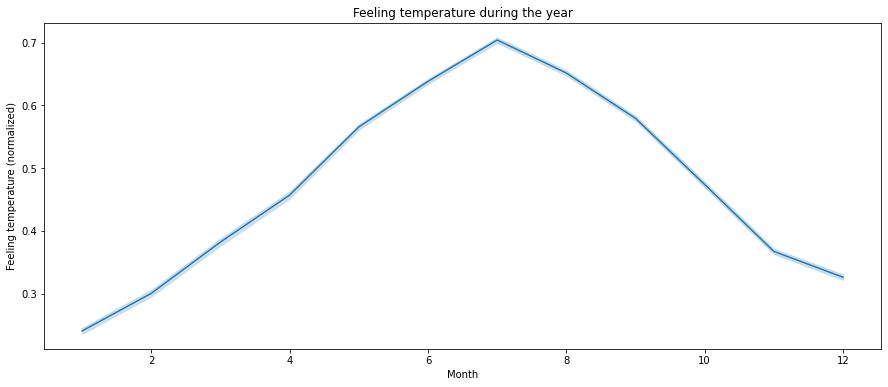

In [ ]:
# graph of feeling temperature during the year
plt.figure(figsize=(15,6))
sns.lineplot(data=df, x="mnth", y="atemp").set(
    title="Feeling temperature during the year",
    xlabel="Month",
    ylabel="Feeling temperature (normalized)"
    );

My assumption is correct. The highest temperature is in July.

Let's check if humidity affects on bike rental.

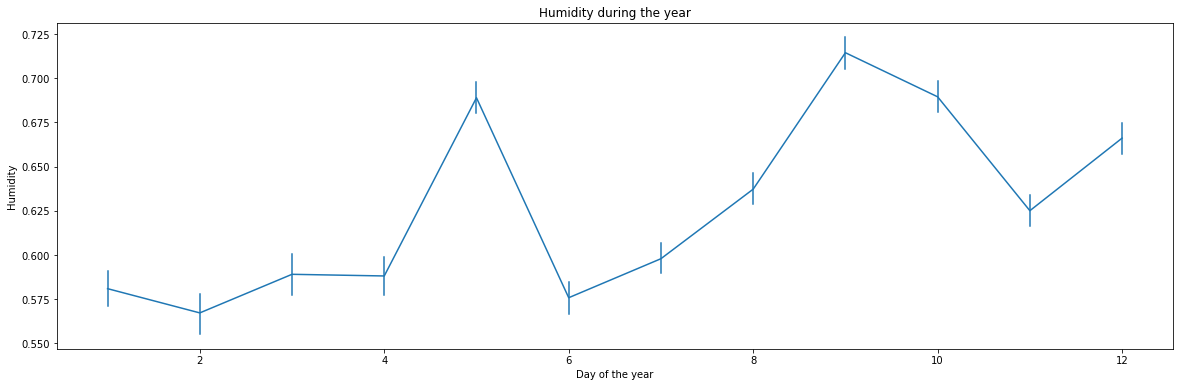

In [ ]:
plt.figure(figsize=(20,6))
sns.lineplot(data=df, x="mnth", y="hum", err_style="bars").set(
    title="Humidity during the year",
    xlabel="Day of the year",
    ylabel="Humidity"
    );

There is no correlation between bike demand and humidity. We can see that during the months with the highest demand on bikes humidity values are both the lowest and the highest.

**hr**: hour (0 to 23)

In [ ]:
df.hr.value_counts()

17    730
16    730
13    729
15    729
14    729
12    728
22    728
21    728
20    728
19    728
18    728
23    728
11    727
10    727
9     727
8     727
7     727
0     726
6     725
1     724
5     717
2     715
4     697
3     697
Name: hr, dtype: int64

In [ ]:
df.hr.sort_values()

0         0
5653      0
5618      0
5594      0
5570      0
         ..
7568     23
7544     23
7520     23
7832     23
17378    23
Name: hr, Length: 17379, dtype: int64

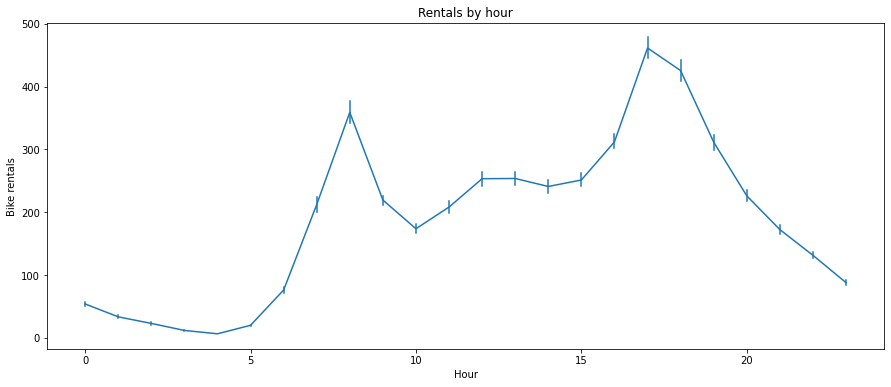

In [ ]:
# lineplot of bikes rented during the day
plt.figure(figsize=(15,6))
sns.lineplot(data=df, x="hr", y="cnt", err_style="bars").set(
    title="Rentals by hour",
    xlabel="Hour",
    ylabel="Bike rentals"
    );

Hour peaks of bike rentals are 8:00 a.m. and 17:00 p.m.

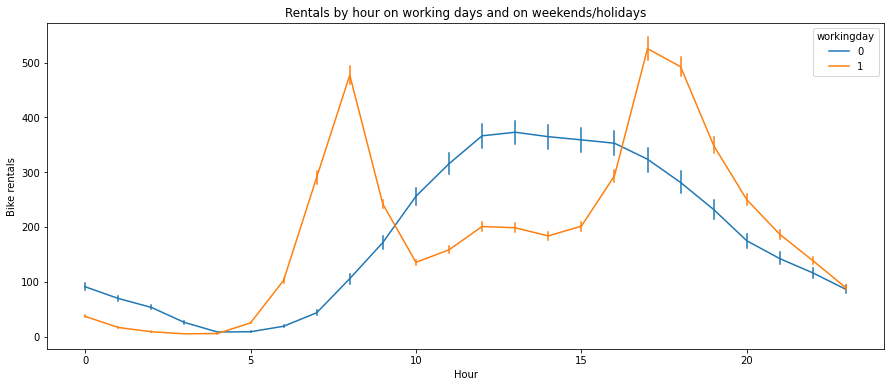

In [ ]:
# lineplot of bikes rented during the working days, and weekends and holidays
plt.figure(figsize=(15,6))
sns.lineplot(data=df, x="hr", y="cnt", err_style="bars", hue="workingday").set(
    title="Rentals by hour on working days and on weekends/holidays",
    xlabel="Hour",
    ylabel="Bike rentals"
    );

We can see that on working days there are two peaks of bike demand - at 8:00 am and 5 pm, and the lowest point is at 4 am; on weekend and holidays the demand is the highest between 12 and 16 pm, and the lowest point is at 5 am.

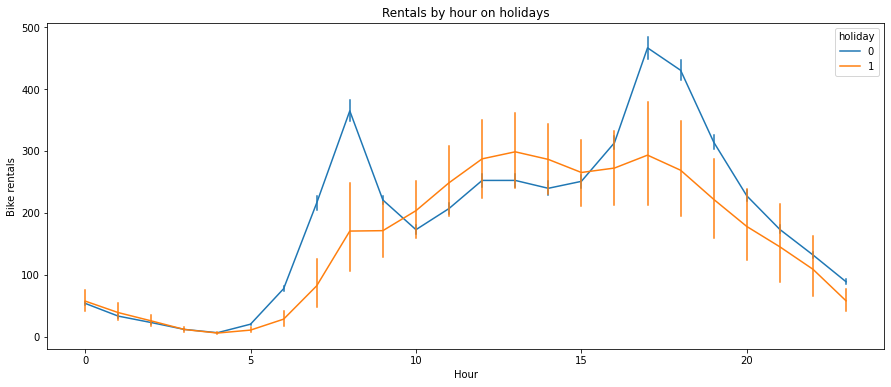

In [ ]:
# lineplot of bikes rented during the holidays relative to working days
plt.figure(figsize=(15,6))
sns.lineplot(data=df, x="hr", y="cnt", err_style="bars", hue="holiday").set(
    title="Rentals by hour on holidays",
    xlabel="Hour",
    ylabel="Bike rentals"
    );

We can see that on holidays the demand is a bit lower relative to weekends.

**holiday**: weather day is holiday or not

In [ ]:
df.holiday.value_counts()

0    16879
1      500
Name: holiday, dtype: int64

In [ ]:
df.holiday.sort_values()

0        0
11496    0
11497    0
11498    0
11499    0
        ..
16422    1
372      1
373      1
16434    1
8689     1
Name: holiday, Length: 17379, dtype: int64

It seems that 0 in 'holiday' means a working day, 1 is a holiday, but it is strange that January 1 is indicated as a working day.

Let's explore what is meant by holidays because:
* over the year 2011, there were 365 days, 251 working days, 11 public holidays, 105 weekend days. Source: https://www.workingdays.us/workingdays_holidays_2011.htm

* over the year 2012, there were 366 days, 251 working days, 12 public holidays, 105 weekend days. Source: https://www.workingdays.us/workingdays_holidays_2012.htm


There were 106 holidays (public holidays + weekends) in 2011 year and 107 holidays (public holidays + weekends) in 2012. Total is 213, but in the dataset there are 500.

In [ ]:
# let's see what were the days that are indicated as holiday
data_holidays = df[df.holiday == 0]
data_holidays

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [ ]:
data_holiday_grouped = data_holidays.groupby(['dteday'])
data_holiday_grouped.first().head(20)

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
2011-01-02,25,1,0,1,0,0,0,0,2,0.46,0.4545,0.88,0.2985,4,13,17
2011-01-03,48,1,0,1,0,0,1,1,1,0.22,0.1970,0.44,0.3582,0,5,5
2011-01-04,70,1,0,1,0,0,2,1,1,0.16,0.1818,0.55,0.1045,0,5,5
2011-01-05,93,1,0,1,0,0,3,1,1,0.20,0.2576,0.64,0.0000,0,6,6
2011-01-06,116,1,0,1,0,0,4,1,1,0.18,0.2424,0.55,0.0000,0,11,11
2011-01-07,139,1,0,1,0,0,5,1,2,0.20,0.1970,0.64,0.1940,4,13,17
2011-01-08,162,1,0,1,0,0,6,0,2,0.18,0.1970,0.51,0.1642,1,24,25
2011-01-09,186,1,0,1,0,0,0,0,1,0.10,0.0758,0.42,0.3881,1,24,25


Probably by holidays they mean holidays and observances*.

*"observances are remembrance, awareness, and celebration days or events that are not normally days off work. These events are inherently different from public holidays, as they are commonly celebrated regionally, and not nationally. Observances are holidays such as Halloween or Earth Day." (Source: https://www.predicthq.com/blog/observed-holidays-vs-observances-whats-the-difference)

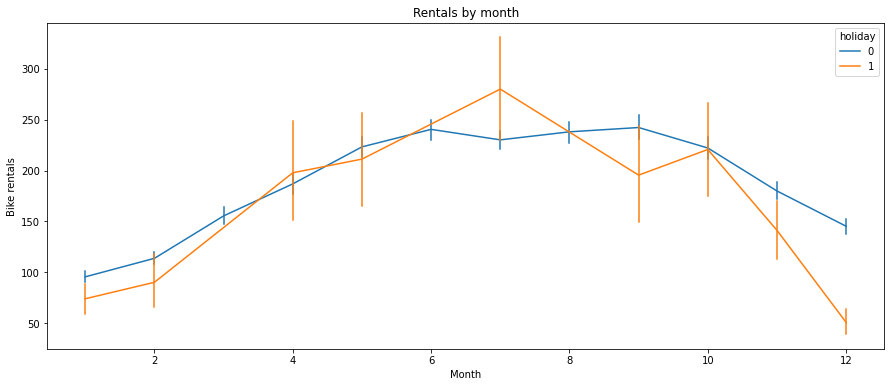

In [ ]:
# lineplot of bike demand during the year
plt.figure(figsize=(15,6))
sns.lineplot(data=df, x="mnth", y="cnt", err_style="bars", hue="holiday").set(
    title="Rentals by month",
    xlabel="Month",
    ylabel="Bike rentals"
    );

There is no holiday in March and August as we see both on graph and in the table below.

Demand on holidays is higher only in April and July.

In [ ]:
df_season = df.groupby(['holiday', 'mnth'])
df_season.first()

instant      dteday  season  yr  hr  weekday  workingday  \
holiday mnth                                                             
0       1           1  2011-01-01       1   0   0        6           0   
        2         689  2011-02-01       1   0   0        2           1   
        3        1338  2011-03-01       1   0   0        2           1   
        4        2068  2011-04-01       2   0   0        5           1   
        5        2787  2011-05-01       2   0   0        0           0   
        6        3531  2011-06-01       2   0   0        3           1   
        7        4251  2011-07-01       3   0   0        5           1   
        8        4995  2011-08-01       3   0   0        1           1   
        9        5726  2011-09-01       3   0   0        4           1   
        10       6443  2011-10-01       4   0   0        6           0   
        11       7186  2011-11-01       4   0   0        2           1   
        12       7905  2011-12-01       4   0   0        4           1   
1       1         373  2011-01-17       1   0   0        1           0   
        2        1158  2011-02-21       1   0   0        1           0   
        4        2403  2011-04-15       2   0   0        5           0   
        5        3483  2011-05-30       2   0   0        1           0   
        7        4323  2011-07-04       3   0   0        1           0   
        9        5822  2011-09-05       3   0   0        1           0   
        10       6659  2011-10-10       4   0   0        1           0   
        11       7426  2011-11-11       4   0   0        5           0   
        12       8504  2011-12-26       1   0   0        1           0   

              weathersit  temp   atemp   hum  windspeed  casual  registered  \
holiday mnth                                                                  
0       1              1  0.24  0.2879  0.81     0.0000       3          13   
        2              2  0.16  0.1818  0.64     0.1045       2           6   
        3              1  0.30  0.2727  0.70     0.4627       0           7   
        4              3  0.26  0.2576  1.00     0.1642       0           6   
        5              1  0.42  0.4242  0.67     0.0896      19          77   
        6              1  0.70  0.6667  0.79     0.1642       9          25   
        7              1  0.66  0.6212  0.50     0.0000      20          48   
        8              1  0.72  0.6818  0.70     0.2239       7          22   
        9              1  0.60  0.5758  0.78     0.1045      18          33   
        10             1  0.50  0.4848  0.63     0.3881      24         106   
        11             2  0.36  0.3485  0.87     0.1642       3          18   
        12             1  0.28  0.2576  0.52     0.3284       1          19   
1       1              2  0.20  0.1970  0.47     0.2239       1          16   
        2              2  0.34  0.3030  0.42     0.3284       7          30   
        4              1  0.44  0.4394  0.67     0.0000       6          21   
        5              1  0.64  0.5606  0.94     0.1940      38          65   
        7              1  0.64  0.5758  0.83     0.1343      63          77   
        9              2  0.70  0.6667  0.74     0.2239      31          66   
        10             1  0.50  0.4848  0.94     0.0000      11          42   
        11             1  0.34  0.3182  0.53     0.2537      10          56   
        12             1  0.22  0.2273  0.75     0.1642       5           6   

              cnt  
holiday mnth       
0       1      16  
        2       8  
        3       7  
        4       6  
        5      96  
        6      34  
        7      68  
        8      29  
        9      51  
        10    130  
        11     21  
        12     20  
1       1      17  
        2      37  
        4      27  
        5     103  
        7     140  
        9      97  
        10     53  
        11     66  
        12     11

**weekday** - day of the week

In [ ]:
df.weekday.value_counts()

6    2512
0    2502
5    2487
1    2479
3    2475
4    2471
2    2453
Name: weekday, dtype: int64

In [ ]:
df.weekday.sort_values()

10990    0
11669    0
11668    0
11667    0
11666    0
        ..
12654    6
12655    6
12656    6
12643    6
0        6
Name: weekday, Length: 17379, dtype: int64

Days are encoded like so: 0 is Sunday, 1 is Moday, 2 is Tuesday, 3 is Wendnesday, 4 is Thursday, 5 is Friday, 6 is Saturday.

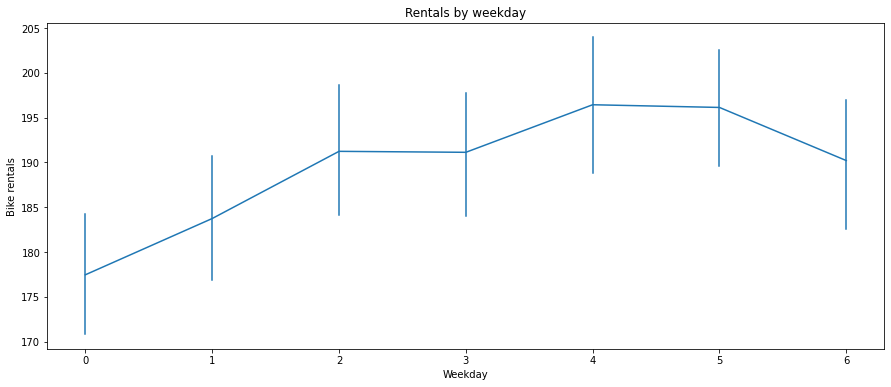

In [ ]:
# lineplot of bike demand during the week
plt.figure(figsize=(15,6))
sns.lineplot(data=df, x="weekday", y="cnt", err_style="bars").set(
    title="Rentals by weekday",
    xlabel="Weekday",
    ylabel="Bike rentals"
    );

The highest demand for bikes are on Thursday, Friday, and Saturday; the lowest demand is on Sunday.

**workingday** - if day is neither weekend nor holiday is 1, otherwise is 0

In [ ]:
df.workingday.value_counts()

1    11865
0     5514
Name: workingday, dtype: int64

In [ ]:
df.workingday.sort_values()

0        0
8645     0
8644     0
8643     0
8642     0
        ..
2705     1
2704     1
2703     1
2725     1
17378    1
Name: workingday, Length: 17379, dtype: int64

**weathersit**

1: Clear, Few clouds, Partly cloudy, Partly cloudy\
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist\
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds\
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

In [ ]:
df.weathersit.value_counts()

1    11413
2     4544
3     1419
4        3
Name: weathersit, dtype: int64

In [ ]:
df.weathersit.sort_values()

0        1
10394    1
10395    1
10396    1
10397    1
        ..
8855     3
13379    3
9123     4
8854     4
585      4
Name: weathersit, Length: 17379, dtype: int64

**temp**: Normalized temperature in Celsius. The values are divided to 41 (max)

In [ ]:
df.temp.value_counts()

0.62    726
0.66    693
0.64    692
0.70    690
0.60    675
0.36    671
0.34    645
0.30    641
0.40    614
0.32    611
0.56    579
0.72    570
0.54    569
0.46    559
0.26    559
0.52    556
0.42    548
0.50    531
0.24    522
0.74    516
0.44    507
0.22    421
0.76    396
0.38    372
0.20    354
0.68    349
0.80    325
0.58    305
0.28    301
0.48    288
0.16    230
0.82    213
0.78    169
0.18    155
0.14    138
0.84    138
0.86    131
0.90     90
0.12     76
0.88     53
0.10     51
0.92     49
0.94     17
0.08     17
0.02     17
0.04     16
0.06     16
0.96     16
0.98      1
1.00      1
Name: temp, dtype: int64

In [ ]:
df.temp.sort_values()

8721     0.02
8719     0.02
8720     0.02
8722     0.02
8723     0.02
         ... 
4936     0.96
4937     0.96
4938     0.96
12972    0.98
13163    1.00
Name: temp, Length: 17379, dtype: float64

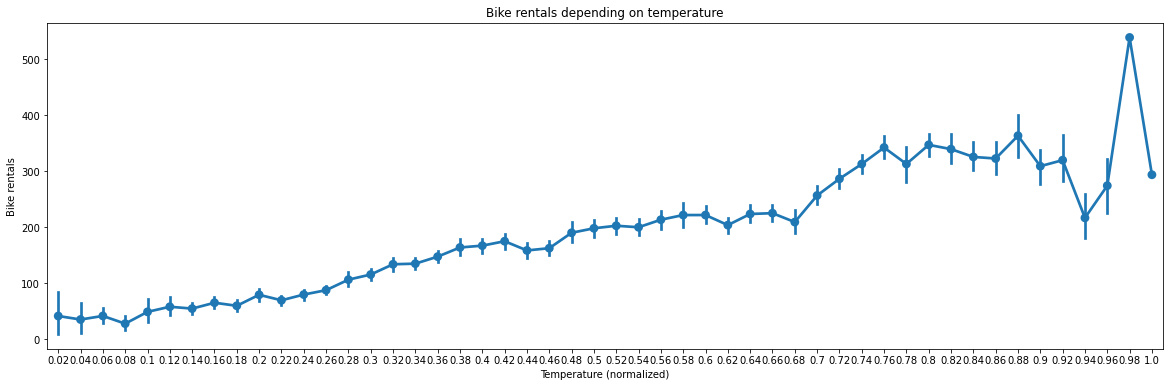

In [ ]:
# plot of bike demand dependeing on temperature
plt.figure(figsize=(20,6))
sns.pointplot(data=df, x="temp", y="cnt", err_style="bars").set(
    title="Bike rentals depending on temperature",
    xlabel="Temperature (normalized)",
    ylabel="Bike rentals"
    );

Rental grows when temperature rises but falls when it's too hot. However, as we can see in the graph it was a peak demand when it was hot. Let's see what the day it was.

In [ ]:
# what was the day and time with the highest temperature - working Friday in June 29 of 2011 at 17:00
df.loc[df['temp'] ==0.98]

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
12972,12973,2012-06-29,3,1,6,17,0,5,1,1,0.98,0.9242,0.34,0.194,82,457,539


**atemp**: Normalized feeling temperature in Celsius. The values are divided to 50 (max)

In [ ]:
df.atemp.value_counts()

0.6212    988
0.5152    618
0.4091    614
0.3333    600
0.6667    593
         ... 
0.0152      4
0.0000      2
0.9848      2
0.9545      1
1.0000      1
Name: atemp, Length: 65, dtype: int64

In [ ]:
df.atemp.sort_values()

480     0.0000
486     0.0000
8718    0.0152
485     0.0152
8719    0.0152
         ...  
4764    0.9242
4766    0.9545
4769    0.9848
4767    0.9848
4768    1.0000
Name: atemp, Length: 17379, dtype: float64

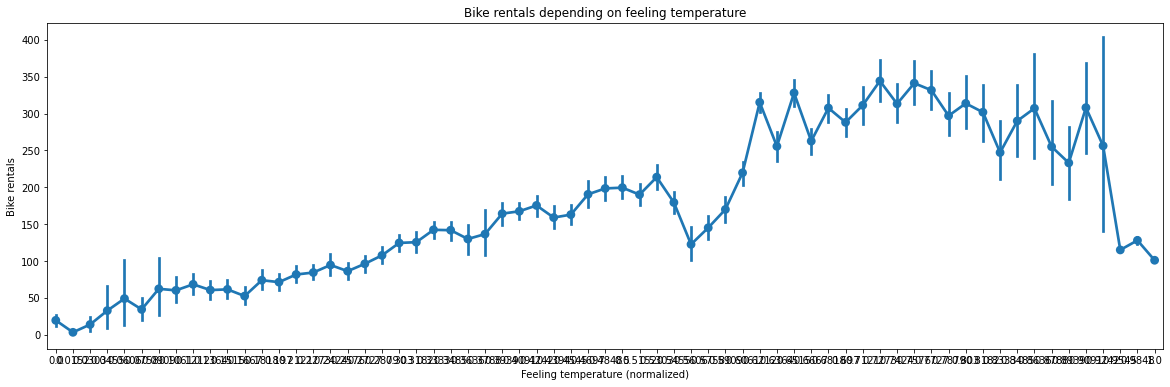

In [ ]:
# plot of bike demand dependeing on feeling temperature
plt.figure(figsize=(20,6))
sns.pointplot(data=df, x="atemp", y="cnt", err_style="bars").set(
    title="Bike rentals depending on feeling temperature",
    xlabel="Feeling temperature (normalized)",
    ylabel="Bike rentals"
    );

As with 'temp', rental grows when feeling temperature rises but falls when it's too hot. Of course, feeling temperature is more important factor than just degress that temperature gauge shows because it is a measurement of how hot or cold it really feels like outside.

**hum**: Normalized humidity. The values are divided to 100 (max)

In [ ]:
df.hum.value_counts()

0.88    657
0.83    630
0.94    560
0.87    488
0.70    430
       ... 
0.12      1
0.08      1
0.10      1
0.97      1
0.91      1
Name: hum, Length: 89, dtype: int64

In [ ]:
df.hum.sort_values()

1565     0.0
1570     0.0
1568     0.0
1567     0.0
1566     0.0
        ... 
16866    1.0
2263     1.0
2262     1.0
3128     1.0
8044     1.0
Name: hum, Length: 17379, dtype: float64

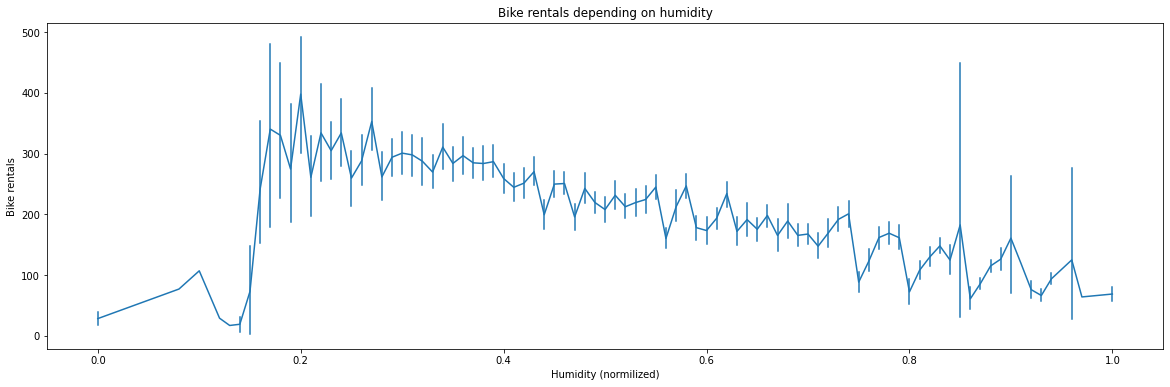

In [ ]:
# lineplot of bike demand depending on humidity
plt.figure(figsize=(20,6))
sns.lineplot(data=df, x="hum", y="cnt", err_style="bars").set(
    title="Bike rentals depending on humidity",
    xlabel="Humidity (normilized)",
    ylabel="Bike rentals"
    );

**windspeed**: Normalized wind speed. The values are divided to 67 (max)

In [ ]:
df.windspeed.value_counts()

0.0000    2180
0.1343    1738
0.1642    1695
0.1940    1657
0.1045    1617
0.2239    1513
0.0896    1425
0.2537    1295
0.2836    1048
0.2985     808
0.3284     602
0.3582     460
0.3881     381
0.4179     296
0.4478     176
0.4627     146
0.4925     112
0.5224      84
0.5821      44
0.5522      39
0.6119      23
0.6418      14
0.6567      11
0.6866       5
0.7463       2
0.8060       2
0.8507       2
0.7164       2
0.7761       1
0.8358       1
Name: windspeed, dtype: int64

In [ ]:
df.windspeed.sort_values()

0        0.0000
11542    0.0000
3294     0.0000
11514    0.0000
11513    0.0000
          ...  
1259     0.8060
9956     0.8060
5635     0.8358
4315     0.8507
4316     0.8507
Name: windspeed, Length: 17379, dtype: float64

**casual**: count of casual users

In [ ]:
df.casual.value_counts()

0      1581
1      1082
2       798
3       697
4       561
       ... 
332       1
361       1
356       1
331       1
304       1
Name: casual, Length: 322, dtype: int64

In [ ]:
df.casual.sort_values()

10894      0
1317       0
2742       0
2743       0
8860       0
        ... 
11986    356
10476    357
11985    361
15343    362
10477    367
Name: casual, Length: 17379, dtype: int64

**registered**: count of registered users

In [ ]:
df.registered.value_counts()

4      307
3      294
5      287
6      266
2      245
      ... 
645      1
610      1
783      1
626      1
585      1
Name: registered, Length: 776, dtype: int64

In [ ]:
df.registered.sort_values()

3988       0
6012       0
5989       0
210        0
1880       0
        ... 
15756    871
15780    876
15108    876
14964    885
14773    886
Name: registered, Length: 17379, dtype: int64

**cnt**: count of total bikes both casual and registered rented per hour

In [ ]:
df.cnt.value_counts()

5      260
6      236
4      231
3      224
2      208
      ... 
913      1
847      1
777      1
661      1
636      1
Name: cnt, Length: 869, dtype: int64

In [ ]:
df.cnt.sort_values()

10896      1
8052       1
10201      1
210        1
212        1
        ... 
15084    967
14725    968
14748    970
14964    976
14773    977
Name: cnt, Length: 17379, dtype: int64

In [ ]:
# 'cnt' distirbution is right-skewed with the peak in the range of 1-9
fig = px.histogram(df, x="cnt")
fig.show()

In [ ]:
# what was the day and time with max rentals: working Wednesday in September of 2012 at 18:00 hr
df.loc[df['cnt'] == 977]

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
14773,14774,2012-09-12,3,1,9,18,0,3,1,1,0.66,0.6212,0.44,0.2537,91,886,977


# Data Preparation and Preprocessing

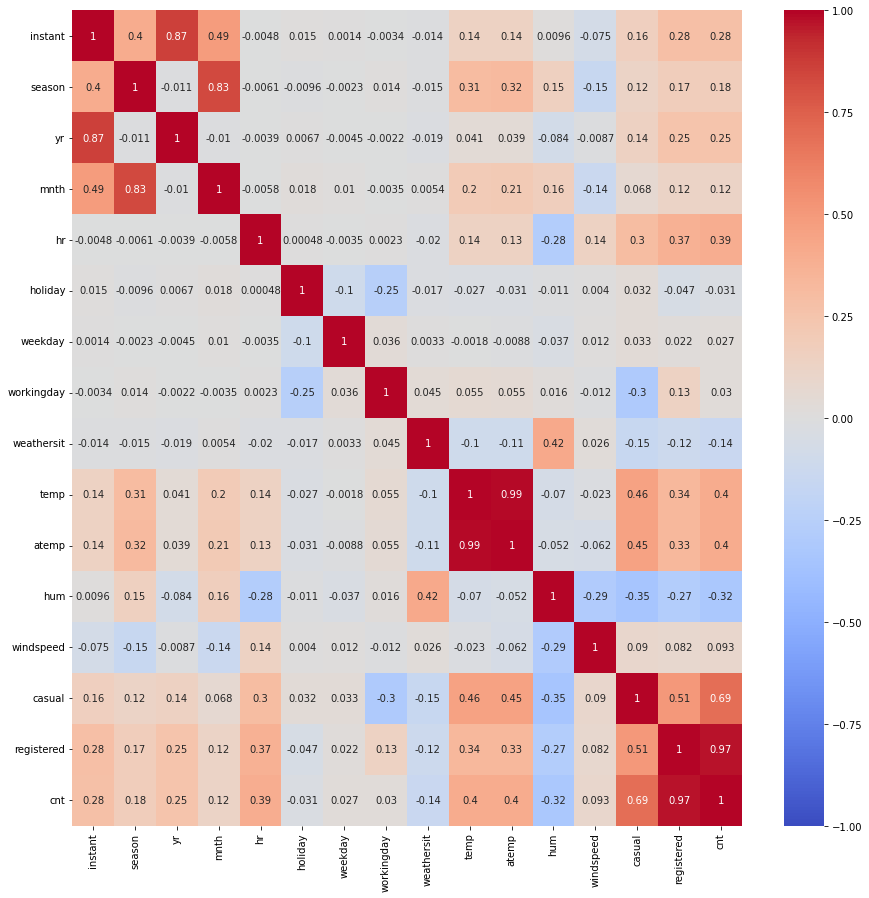

In [ ]:
# correlation matrix
f, ax = plt.subplots(figsize = (15, 15))
sns.heatmap(df.corr(),  vmin = -1, vmax = 1, cmap = 'coolwarm', annot = True)
plt.show()

**Positive correlation with target 'cnt'**\
Strong correlation (> 0.7): 'registered'\
Moderate correlation (0.5-0.7): 'casual'\
Low correlation (0.3-0.5): 'temp', 'atemp', 'hr'

In [ ]:
# 1) since there is a strong correlation between 'temp' and 'atemp'
# it's reasonable to drop 'temp' column as feeling temperature is more important feature
# 2) drop 'instant' column as it doesn't bring much to a model
# 3) drop 'season' column as its values are wrong and 'mnth' column's info is enough to identify a season
df.drop(columns = ['temp', 'instant', 'season'], inplace = True)

In [ ]:
# expand datetime column to get day of the week and day of the month values
# first, convert datetime string to datetime format
df['dteday'] = pd.to_datetime(df['dteday'])
df = df.set_index(df['dteday'])

In [ ]:
# extract info about day
df['day_of_month'] = df.index.day

In [ ]:
# drop 'dteday' column
df.drop(columns = ['dteday'], inplace = True)

In [ ]:
df.head()

,yr,mnth,hr,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,casual,registered,cnt,day_of_month
dteday,,,,,,,,,,,,,,
2011-01-01,0,1,0,0,6,0,1,0.2879,0.81,0.0,3,13,16,1
2011-01-01,0,1,1,0,6,0,1,0.2727,0.80,0.0,8,32,40,1
2011-01-01,0,1,2,0,6,0,1,0.2727,0.80,0.0,5,27,32,1
2011-01-01,0,1,3,0,6,0,1,0.2879,0.75,0.0,3,10,13,1
2011-01-01,0,1,4,0,6,0,1,0.2879,0.75,0.0,0,1,1,1


We have some categorical variables that are encoded into numbers. That's why we have to decode it and then ecnode it with the help of dummy variables.

In [ ]:
# there is only 3 instances in 'rain' subset of 'wethersit' column
# so let's merge it with 'heavy_rain' subset
df["weathersit"].replace(to_replace="heavy_rain", value="rain", inplace=True)

In [ ]:
# categories described as numbers
year_mapping = dict(zip(range(0, 2), ["2011", "2012"]))

month_mapping = dict(zip(range(1, 13), ['Jan', 'Feb', 'Mar','Apr', 'May', 'Jun',
                                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']))
hour_mapping = dict(zip(range(0, 24), ['0', '1', '2', '3', '4', '5', '6', '7', '8', \
                                       '9', '10', '11', '12', '13', '14', '15', \
                                       '16', '17', '18', '19', '20', '21', '22', '23']))

holiday_mapping = dict(zip(range(0, 2), ["no", "yes"]))

weekday_mapping = dict(zip(range(0, 7), ['Sun', 'Mon', 'Tue','Wed', 'Thu', 'Fri', 'Sat']))

working_day_mapping = dict(zip(range(0, 2), ["non_work", "work"]))

weather_mapping = dict(zip(range(1, 4), ["clear", "misty", "rain"]))

day_of_month_mapping = dict(zip(range(1, 32), ['0', '1', '2', '3', '4', '5', '6', '7', '8', \
                                       '9', '10', '11', '12', '13', '14', '15', \
                                       '16', '17', '18', '19', '20', '21', '22', '23',
                                       '24', '25', '26', '27', '28', '29', '30', '31']))

In [ ]:
df.loc[:, 'yr'] = df.yr.map(year_mapping)
df.loc[:, 'mnth'] = df.mnth.map(month_mapping)
df.loc[:, 'hr'] = df.hr.map(hour_mapping)
df.loc[:, 'holiday'] = df.holiday.map(holiday_mapping)
df.loc[:, 'weekday'] = df.weekday.map(weekday_mapping)
df.loc[:, 'workingday'] = df.workingday.map(working_day_mapping)
df.loc[:, 'weathersit'] = df.weathersit.map(weather_mapping)
df.loc[:, 'day_of_month'] = df.day_of_month.map(day_of_month_mapping)

In [ ]:
categorical_columns = [
    "yr",
    "mnth",
    "hr",
    "holiday",
    "weekday",
    "workingday",
    "weathersit",
    "day_of_month"
]

In [ ]:
df = df.copy()
cat_encoded = pd.get_dummies(df[categorical_columns])
df.drop(columns=categorical_columns, inplace=True)
df = pd.concat((df, cat_encoded), axis=1)

In [ ]:
df.shape

(17379, 89)

In [ ]:
df.head()

,atemp,hum,windspeed,casual,registered,cnt,yr_2011,yr_2012,mnth_Apr,mnth_Aug,...,day_of_month_28,day_of_month_29,day_of_month_3,day_of_month_30,day_of_month_4,day_of_month_5,day_of_month_6,day_of_month_7,day_of_month_8,day_of_month_9
dteday,,,,,,,,,,,,,,,,,,,,,
2011-01-01,0.2879,0.81,0.0,3,13,16,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2011-01-01,0.2727,0.80,0.0,8,32,40,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2011-01-01,0.2727,0.80,0.0,5,27,32,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2011-01-01,0.2879,0.75,0.0,3,10,13,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2011-01-01,0.2879,0.75,0.0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Keep only date and target.

In [ ]:
# create new data set containing only date as index and target
data = df[['cnt']]
data.head()

,cnt
dteday,
2011-01-01,16
2011-01-01,40
2011-01-01,32
2011-01-01,13
2011-01-01,1


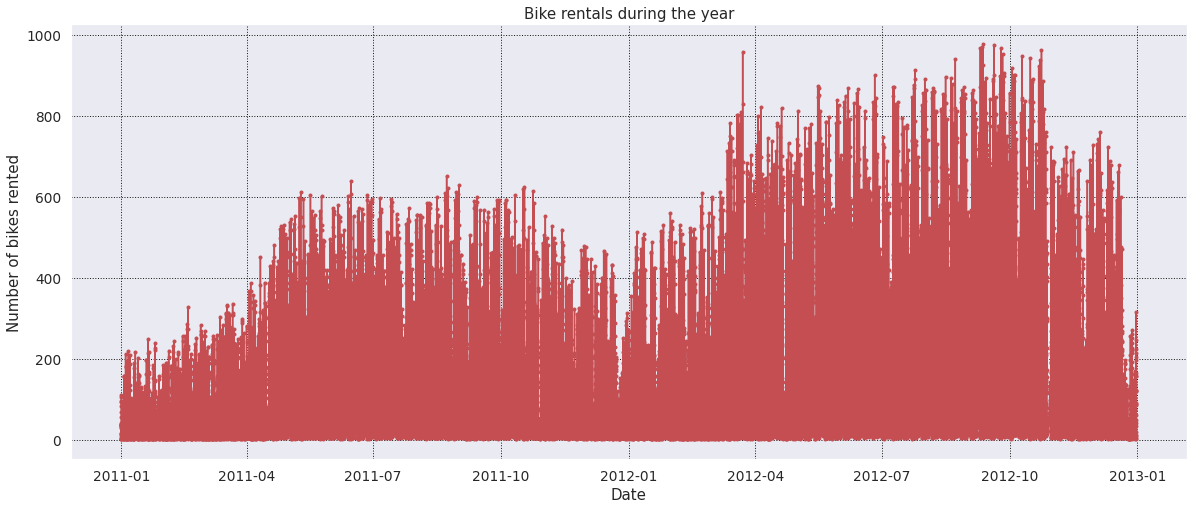

In [ ]:
plt.subplots(1, 1, figsize=(20, 8))

plt.plot(data, '-ro', markersize=3)
plt.plot(data.index[0], 0)

plt.grid(linestyle=':', color='k')
plt.xlabel("Date")
plt.ylabel("Number of bikes rented")
plt.title("Bike rentals during the year")
plt.show()

We can observe multiplicative time series.

## Test for stationarity

In [ ]:
y = data['cnt']

In [ ]:
# ADF test (Null hypothesis - The process is non-stationary)
alpha = 0.05
print(f"alpha = {alpha}\n")

result = adfuller(y, autolag='AIC')
print(f'ADF Statistic: {result[0]:.4g}')
print(f'p-value: {result[1]:.4g}')
if result[1] < alpha:
    print("The process is stationary.")
else:
    print("The process is non-stationary.")

alpha = 0.05

ADF Statistic: -6.823
p-value: 1.981e-09
The process is stationary.


In [ ]:
# KPSS test (null hypothesis - the process is stationary)
kpsstest = kpss(y, regression='c')
print(f"KPSS Statistic = {kpsstest[0]:.4g}")
print(f"p-value = {kpsstest[1]:.4g}")
if kpsstest[1] < alpha:
    print("The process is non-stationary.")
else:
    print("The process is stationary.")

KPSS Statistic = 19.94
p-value = 0.01
The process is non-stationary.


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


ADF test shows that the process is stationary, but KPSS test shows that the process is non-stationaty. It means that the series is difference stationary and we have to achieve stationarity by differencing.

## Time Series Decomposition

<ipython-input-213-bcb3b17e0e78>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gd" (-> color='g'). The keyword argument will take precedence.
  plt.plot(decomposition.seasonal,


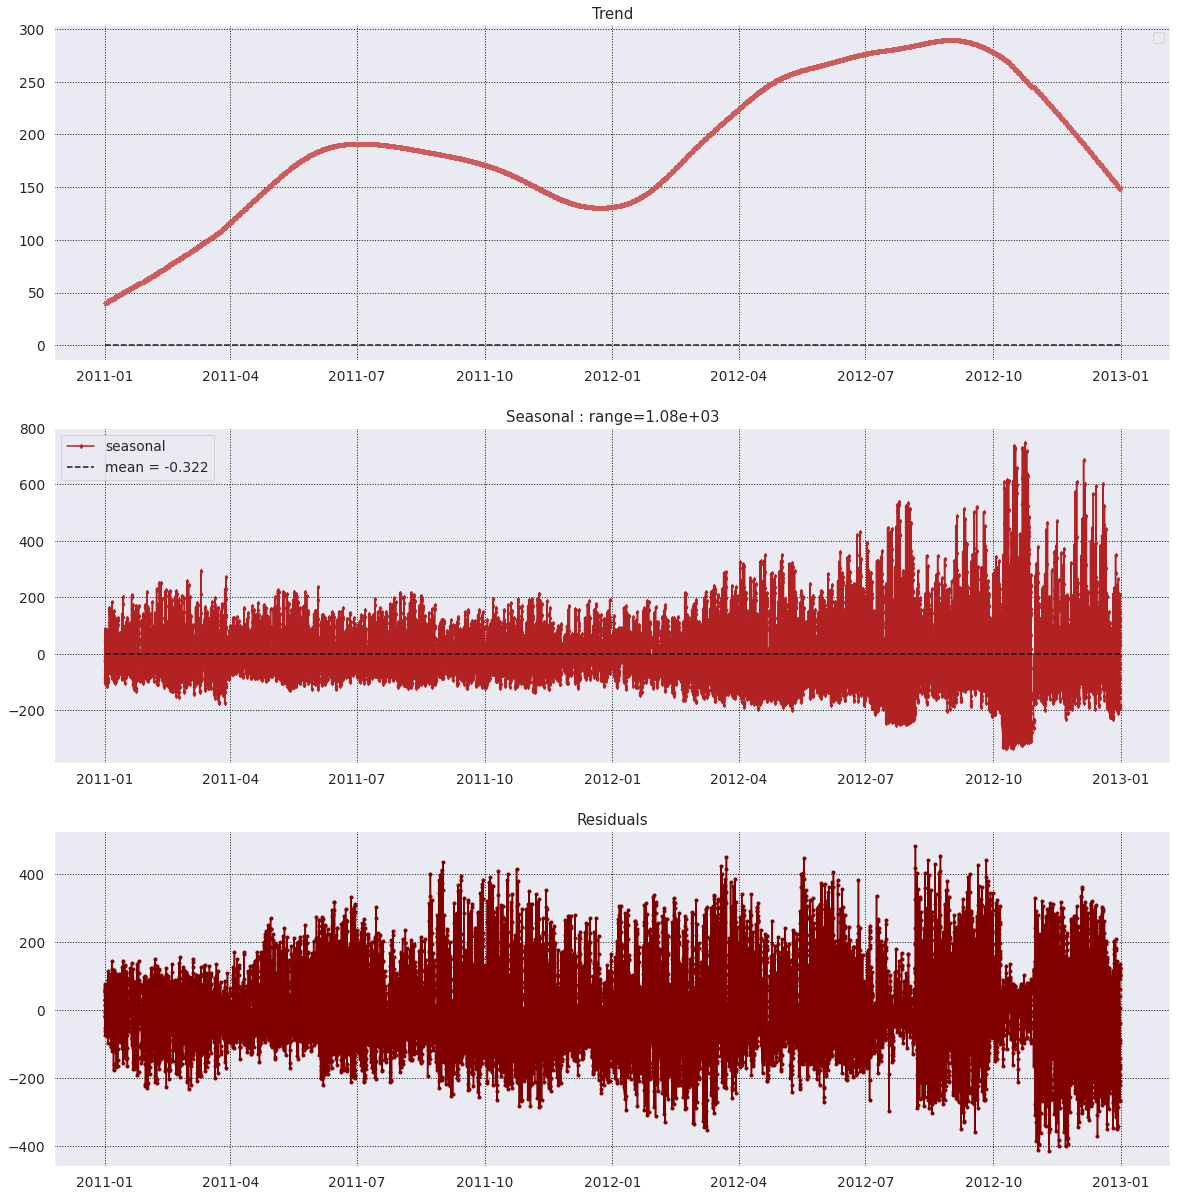

In [ ]:
stl = STL(y, period=24*7*12)
decomposition = stl.fit()


plt.subplots(3, 1, figsize=(20, 21))

plt.subplot(3, 1, 1)
plt.plot(decomposition.trend, '-d', color='indianred', markersize=3)
plt.plot([decomposition.trend.index[0], decomposition.trend.index[-1]], [0, 0], '--k')
plt.legend()
plt.grid(linestyle=':', color='k')
plt.title("Trend")


plt.subplot(3, 1, 2)
plt.plot(decomposition.seasonal,
         '-gd', color='firebrick', markersize=3, label='seasonal')
plt.plot([decomposition.seasonal.index[0], decomposition.seasonal.index[-1]],
         decomposition.seasonal.mean()*np.array([1, 1]), '--k',
         label=f"mean = {decomposition.seasonal.mean():.3g}")
plt.legend()
plt.grid(linestyle=':', color='k')
plt.title(f"Seasonal : range={(decomposition.seasonal.max() - decomposition.seasonal.min()):.3g}")


plt.subplot(3, 1, 3)
plt.plot(decomposition.resid, '-o', color='maroon', markersize=3)
plt.grid(linestyle=':', color='k')
plt.title("Residuals")
plt.show()

We can observe additive trend, multiplicative seasonality, and multiplicative error.

### *Analysis of decomposition residuals*

In [ ]:
resid = decomposition.resid

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


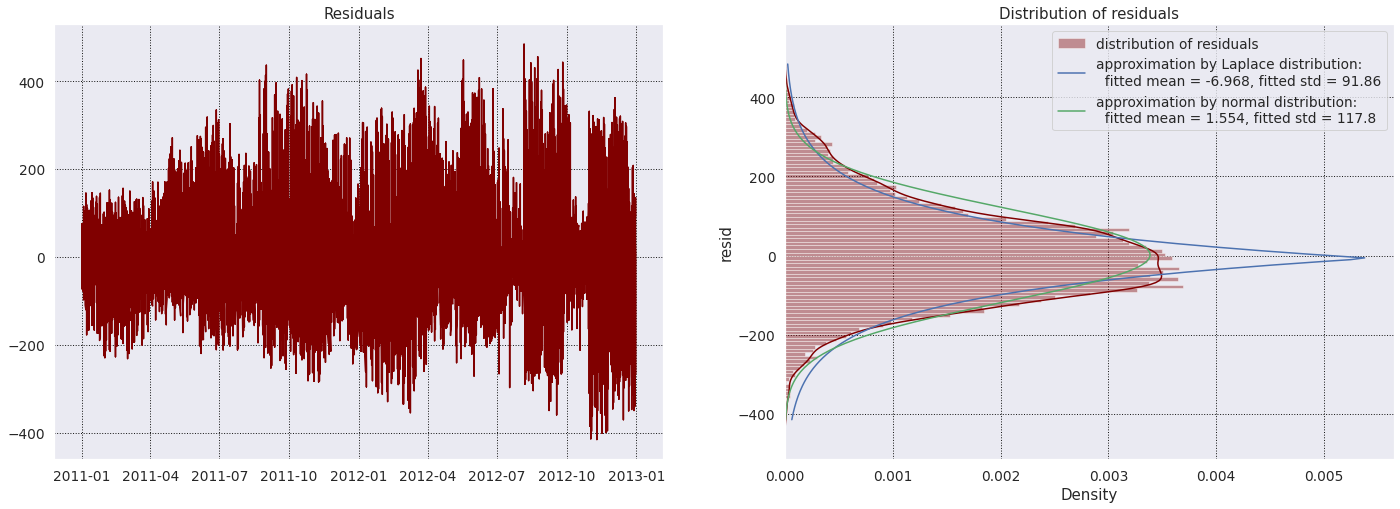

In [ ]:
color = 'maroon'

plt.subplots(1, 2, figsize=(24, 8))

plt.subplot(1, 2, 1)
plt.plot(resid, '-', color=color)
plt.grid(linestyle=':', color='k')
plt.title("Residuals")


x_fit = np.linspace(resid.min(), resid.max(), 201)
loc_laplace, scale_laplace = st.laplace.fit(resid.dropna())
loc_norm, scale_norm = st.norm.fit(resid.dropna())
y_fit_laplace = st.laplace.pdf(x_fit, loc_laplace, scale_laplace)
y_fit_norm = st.norm.pdf(x_fit, loc_norm, scale_norm)

plt.subplot(1, 2, 2)
sns.distplot(resid, color=color, bins=100, vertical=True, label="distribution of residuals")
plt.plot(y_fit_laplace, x_fit, '-b',
         label=f"approximation by Laplace distribution:\n  fitted mean = {loc_laplace:.4g}, fitted std = {scale_laplace:.4g}")
plt.plot(y_fit_norm, x_fit, '-g',
         label=f"approximation by normal distribution:\n  fitted mean = {loc_norm:.4g}, fitted std = {scale_norm:.4g}")
plt.legend()
plt.title("Distribution of residuals")
plt.grid(linestyle=':', color='k')

plt.show()

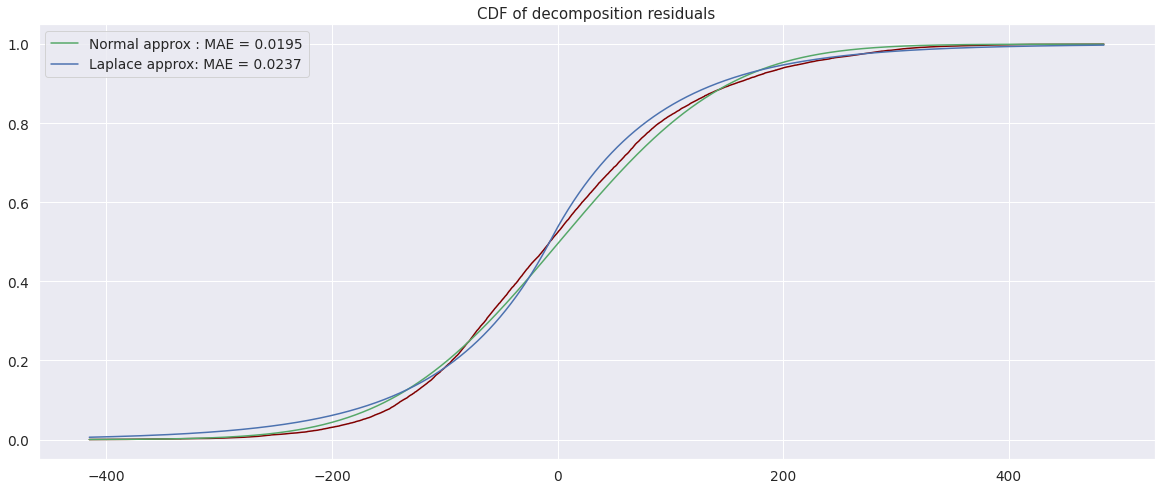

MAE_Gaussian/MAE_Laplace = 0.823.


In [ ]:
ecdf_resid_instance = ECDF(resid.dropna())
resid_arr = resid.dropna().sort_values().values
ecdf_resid = ecdf_resid_instance(resid_arr)


cdf_norm = st.norm.cdf(resid_arr, loc=loc_norm, scale=scale_norm)
cdf_laplace = st.laplace.cdf(resid_arr, loc=loc_laplace, scale=scale_laplace)


mae_norm = mean_absolute_error(ecdf_resid, cdf_norm)
mae_laplace = mean_absolute_error(ecdf_resid, cdf_laplace)


plt.subplots(1, 1, figsize=(20, 8))
plt.plot(resid_arr, ecdf_resid, '-', color='maroon')
plt.plot(resid_arr, cdf_norm, '-g',
         label=f"Normal approx : MAE = {mae_norm:.3g}")
plt.plot(resid_arr, cdf_laplace, '-b',
         label=f"Laplace approx: MAE = {mae_laplace:.3g}")
plt.legend()
plt.title("CDF of decomposition residuals")
plt.show()

print(f"MAE_Gaussian/MAE_Laplace = {mae_norm/mae_laplace:.3g}.")

It looks like residuals have Normal distribution.

**Autocorrelation of residuals**

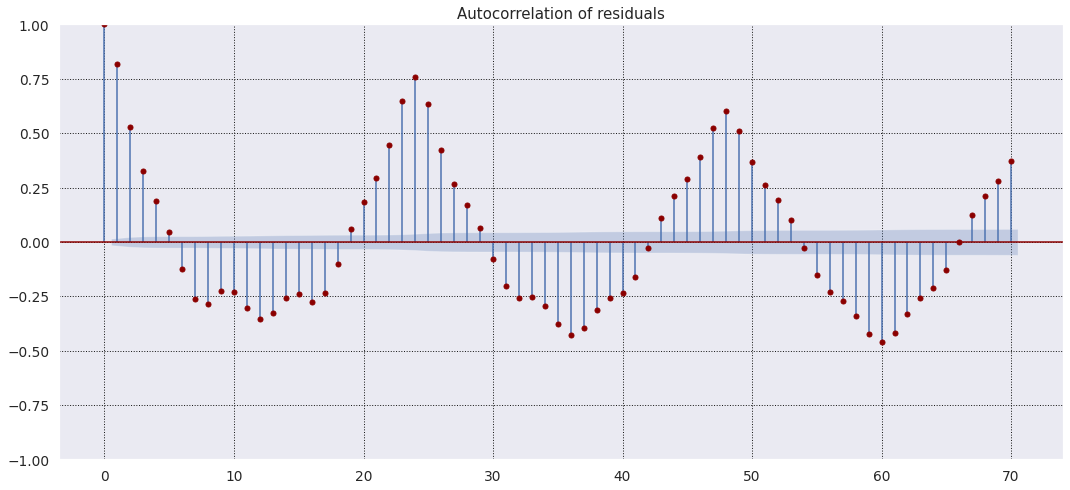

In [ ]:
lags = 70

plot_acf(resid.dropna(), lags=lags, color='darkred',
         title='Autocorrelation of residuals');
plt.grid(linestyle=':', color='k')
plt.show()

These residuals is not a white noise and have a 24-hour periodic component.

**Test for trend stationarity**

In [ ]:
trend = decomposition.trend.dropna()

In [ ]:
#ADF test
alpha = 0.05
print(f"alpha = {alpha}\n")

result = adfuller(trend.dropna(), autolag='AIC')
print(f'ADF Statistic: {result[0]:.4g}')
print(f'p-value: {result[1]:.4g}')
if result[1] < alpha:
    print("The process is stationary.")
else:
    print("The process is non-stationary.")

alpha = 0.05

ADF Statistic: -5.436
p-value: 2.84e-06
The process is stationary.


In [ ]:
# KPSS test
kpsstest = kpss(trend.dropna(), regression='c')
print(f"KPSS Statistic = {kpsstest[0]:.4g}")
print(f"p-value = {kpsstest[1]:.4g}")
if kpsstest[1] < alpha:
    print("The process is non-stationary.")
else:
    print("The process is stationary.")

KPSS Statistic = 14.16
p-value = 0.01
The process is non-stationary.


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


**Test for seasonal stationarity**

In [ ]:
season = decomposition.seasonal.dropna()

In [ ]:
#ADF test
alpha = 0.05
print(f"alpha = {alpha}\n")

result = adfuller(season.dropna(), autolag='AIC')
print(f'ADF Statistic: {result[0]:.4g}')
print(f'p-value: {result[1]:.4g}')
if result[1] < alpha:
    print("The process is stationary.")
else:
    print("The process is non-stationary.")

alpha = 0.05

ADF Statistic: -20.64
p-value: 0
The process is stationary.


In [ ]:
# KPSS test
kpsstest = kpss(season.dropna(), regression='c')
print(f"KPSS Statistic = {kpsstest[0]:.4g}")
print(f"p-value = {kpsstest[1]:.4g}")
if kpsstest[1] < alpha:
    print("The process is non-stationary.")
else:
    print("The process is stationary.")

KPSS Statistic = 0.02877
p-value = 0.1
The process is stationary.


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Let us differentiate trend to get rid of non-stationarity.

Text(0.5, 1.0, '1st derivative of trend')

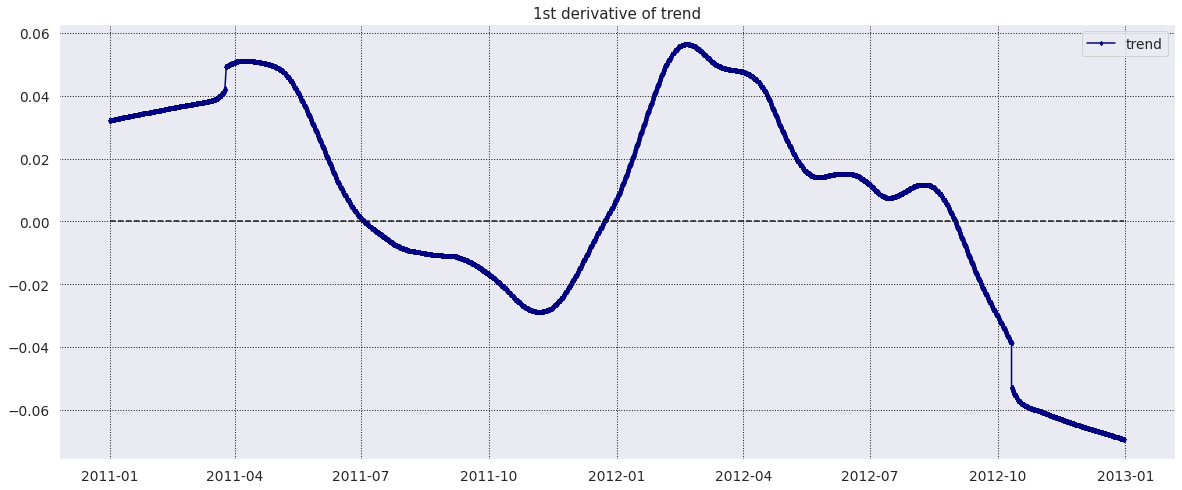

In [ ]:
first_diff = trend.diff().dropna()

plt.subplots(1, 1, figsize=(20, 8))

plt.plot(first_diff, '-d', color='navy', markersize=3, label='trend')
plt.plot([first_diff.index[0], first_diff.index[-1]], [0, 0], '--k')
plt.legend()
plt.grid(linestyle=':', color='k')
plt.title("1st derivative of trend")

Text(0.5, 1.0, '2nd derivative of trend')

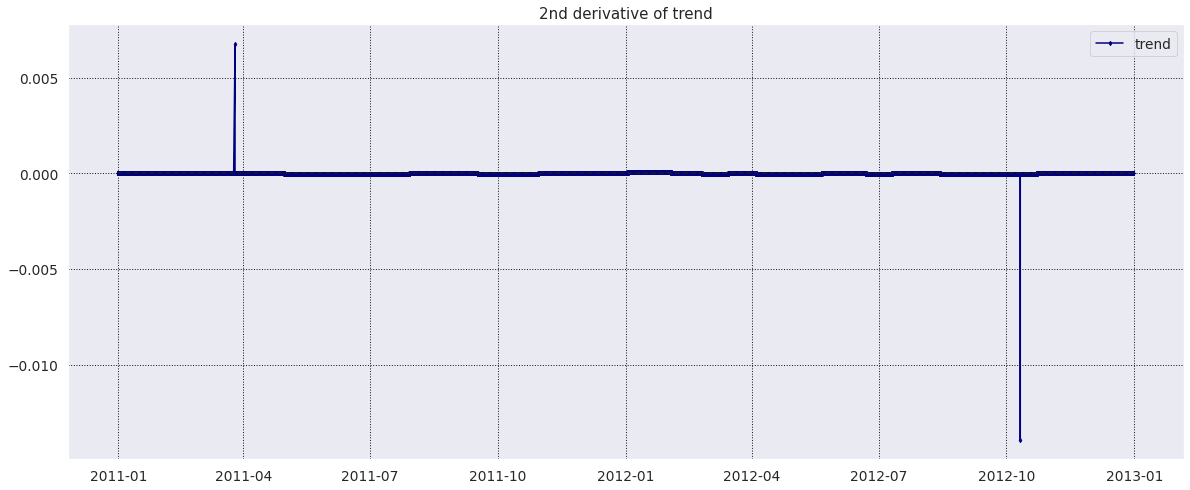

In [ ]:
# second differencing
second_diff = first_diff.diff().dropna()

plt.subplots(1, 1, figsize=(20, 8))

plt.plot(second_diff, '-d', color='navy', markersize=3, label='trend')
plt.plot([second_diff.index[0], second_diff.index[-1]], [0, 0], '--k')
plt.legend()
plt.grid(linestyle=':', color='k')
plt.title("2nd derivative of trend")

Text(0.5, 1.0, '3d derivative of trend')

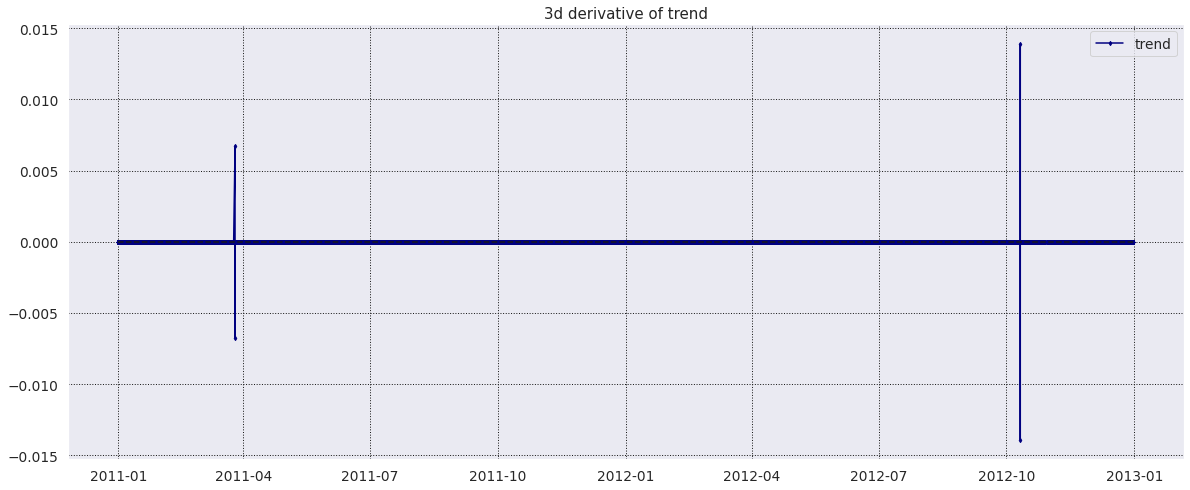

In [ ]:
# third differencing
third_diff = second_diff.diff().dropna()

plt.subplots(1, 1, figsize=(20, 8))

plt.plot(third_diff, '-d', color='navy', markersize=3, label='trend')
plt.plot([third_diff.index[0], third_diff.index[-1]], [0, 0], '--k')
plt.legend()
plt.grid(linestyle=':', color='k')
plt.title("3d derivative of trend")

Tests for stationarity

In [ ]:
#ADF test
alpha = 0.05
print(f"alpha = {alpha}\n")

result = adfuller(third_diff, autolag='AIC')
print(f'ADF Statistic: {result[0]:.4g}')
print(f'p-value: {result[1]:.4g}')
if result[1] < alpha:
    print("The process is stationary.")
else:
    print("The process is non-stationary.")

alpha = 0.05

ADF Statistic: -33.85
p-value: 0
The process is stationary.


In [ ]:
# KPSS test
kpsstest = kpss(third_diff, regression='c')
print(f"KPSS Statistic = {kpsstest[0]:.4g}")
print(f"p-value = {kpsstest[1]:.4g}")
if kpsstest[1] < alpha:
    print("The process is non-stationary.")
else:
    print("The process is stationary.")

KPSS Statistic = 0.5
p-value = 0.04167
The process is non-stationary.


In [ ]:
# first difference
y = data['cnt'].diff().dropna()
y

dteday
2011-01-01    24.0
2011-01-01    -8.0
2011-01-01   -19.0
2011-01-01   -12.0
2011-01-01     0.0
              ... 
2012-12-31    -3.0
2012-12-31   -30.0
2012-12-31     1.0
2012-12-31   -29.0
2012-12-31   -12.0
Name: cnt, Length: 17378, dtype: float64

In [ ]:
# second difference
y = y.diff().dropna()
y

dteday
2011-01-01   -32.0
2011-01-01   -11.0
2011-01-01     7.0
2011-01-01    12.0
2011-01-01     1.0
              ... 
2012-12-31    39.0
2012-12-31   -27.0
2012-12-31    31.0
2012-12-31   -30.0
2012-12-31    17.0
Name: cnt, Length: 17377, dtype: float64

In [ ]:
# third difference
y = y.diff().dropna()
y

dteday
2011-01-01    21.0
2011-01-01    18.0
2011-01-01     5.0
2011-01-01   -11.0
2011-01-01    -1.0
              ... 
2012-12-31    31.0
2012-12-31   -66.0
2012-12-31    58.0
2012-12-31   -61.0
2012-12-31    47.0
Name: cnt, Length: 17376, dtype: float64

In [ ]:
# ADF test
alpha = 0.05
print(f"alpha = {alpha}\n")

result = adfuller(y, autolag='AIC')
print(f'ADF Statistic: {result[0]:.4g}')
print(f'p-value: {result[1]:.4g}')
if result[1] < alpha:
    print("The process is stationary.")
else:
    print("The process is non-stationary.")

alpha = 0.05

ADF Statistic: -57.73
p-value: 0
The process is stationary.


In [ ]:
# KPSS test
kpsstest = kpss(y, regression='c')
print(f"KPSS Statistic = {kpsstest[0]:.4g}")
print(f"p-value = {kpsstest[1]:.4g}")
if kpsstest[1] < alpha:
    print("The process is non-stationary.")
else:
    print("The process is stationary.")

KPSS Statistic = 0.003385
p-value = 0.1
The process is stationary.


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## Time Series Decomposition

<ipython-input-251-bcb3b17e0e78>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gd" (-> color='g'). The keyword argument will take precedence.
  plt.plot(decomposition.seasonal,


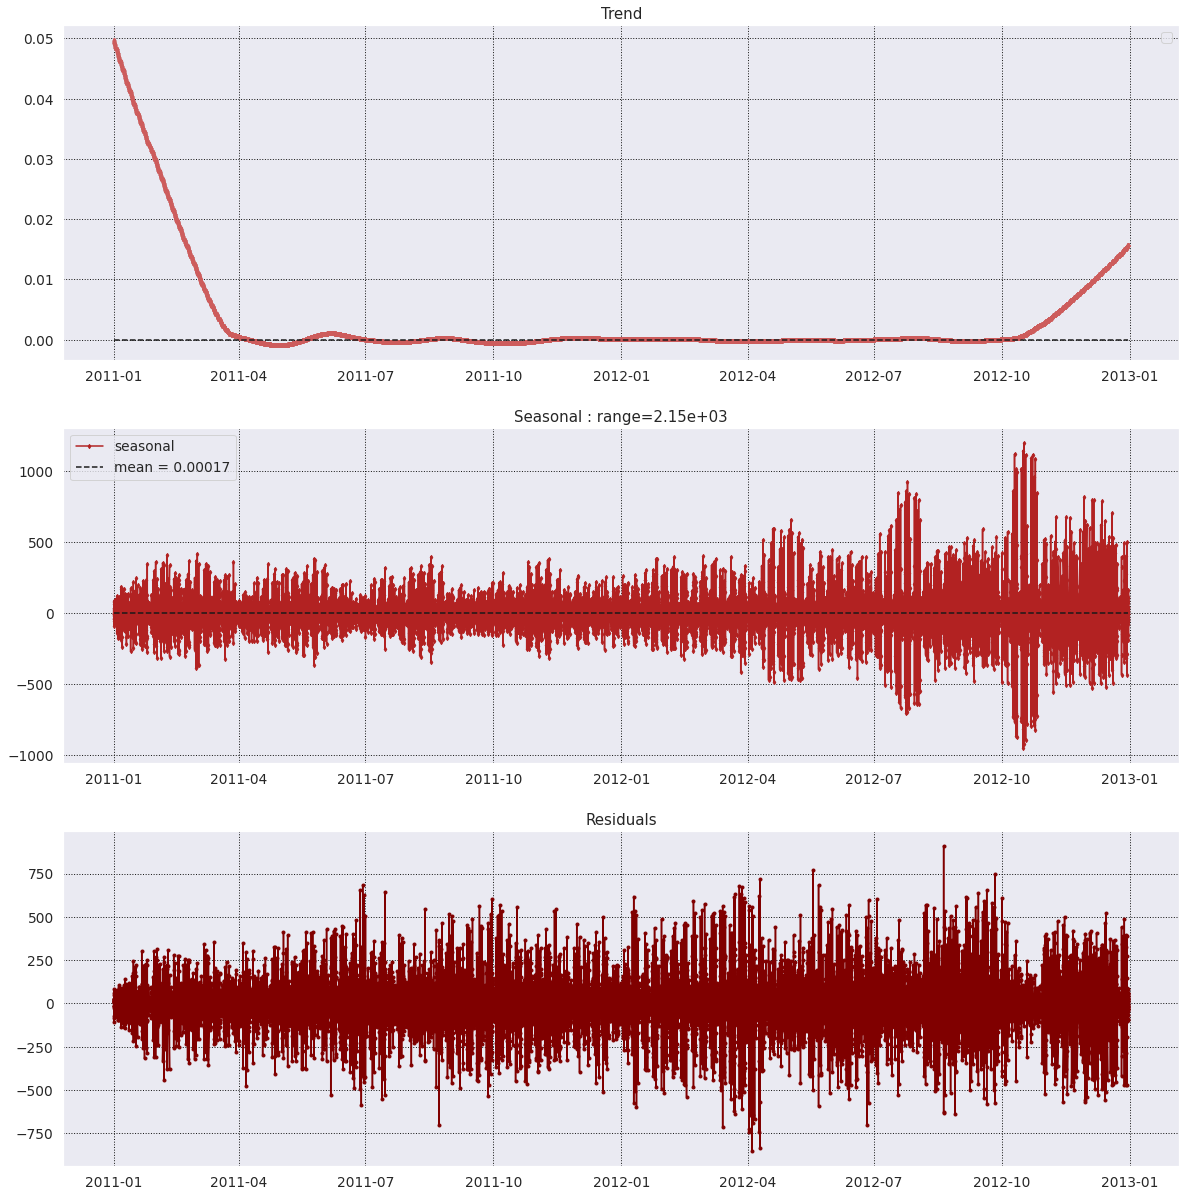

In [ ]:
stl = STL(y, period=24*7*12)
decomposition = stl.fit()


plt.subplots(3, 1, figsize=(20, 21))

plt.subplot(3, 1, 1)
plt.plot(decomposition.trend, '-d', color='indianred', markersize=3)
plt.plot([decomposition.trend.index[0], decomposition.trend.index[-1]], [0, 0], '--k')
plt.legend()
plt.grid(linestyle=':', color='k')
plt.title("Trend")


plt.subplot(3, 1, 2)
plt.plot(decomposition.seasonal,
         '-gd', color='firebrick', markersize=3, label='seasonal')
plt.plot([decomposition.seasonal.index[0], decomposition.seasonal.index[-1]],
         decomposition.seasonal.mean()*np.array([1, 1]), '--k',
         label=f"mean = {decomposition.seasonal.mean():.3g}")
plt.legend()
plt.grid(linestyle=':', color='k')
plt.title(f"Seasonal : range={(decomposition.seasonal.max() - decomposition.seasonal.min()):.3g}")


plt.subplot(3, 1, 3)
plt.plot(decomposition.resid, '-o', color='maroon', markersize=3)
plt.grid(linestyle=':', color='k')
plt.title("Residuals")
plt.show()

### *Analysis of decomposition residuals*

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


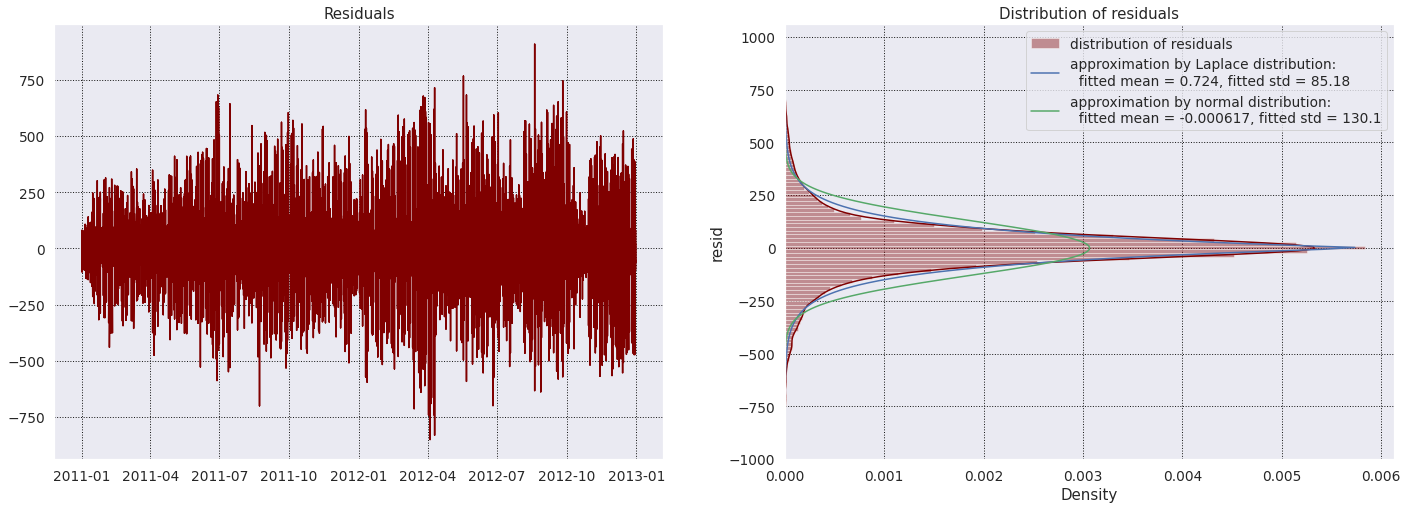

In [ ]:
resid = decomposition.resid
color = 'maroon'

plt.subplots(1, 2, figsize=(24, 8))

plt.subplot(1, 2, 1)
plt.plot(resid, '-', color=color)
plt.grid(linestyle=':', color='k')
plt.title("Residuals")


x_fit = np.linspace(resid.min(), resid.max(), 201)
loc_laplace, scale_laplace = st.laplace.fit(resid.dropna())
loc_norm, scale_norm = st.norm.fit(resid.dropna())
y_fit_laplace = st.laplace.pdf(x_fit, loc_laplace, scale_laplace)
y_fit_norm = st.norm.pdf(x_fit, loc_norm, scale_norm)

plt.subplot(1, 2, 2)
sns.distplot(resid, color=color, bins=100, vertical=True, label="distribution of residuals")
plt.plot(y_fit_laplace, x_fit, '-b',
         label=f"approximation by Laplace distribution:\n  fitted mean = {loc_laplace:.4g}, fitted std = {scale_laplace:.4g}")
plt.plot(y_fit_norm, x_fit, '-g',
         label=f"approximation by normal distribution:\n  fitted mean = {loc_norm:.4g}, fitted std = {scale_norm:.4g}")
plt.legend()
plt.title("Distribution of residuals")
plt.grid(linestyle=':', color='k')

plt.show()

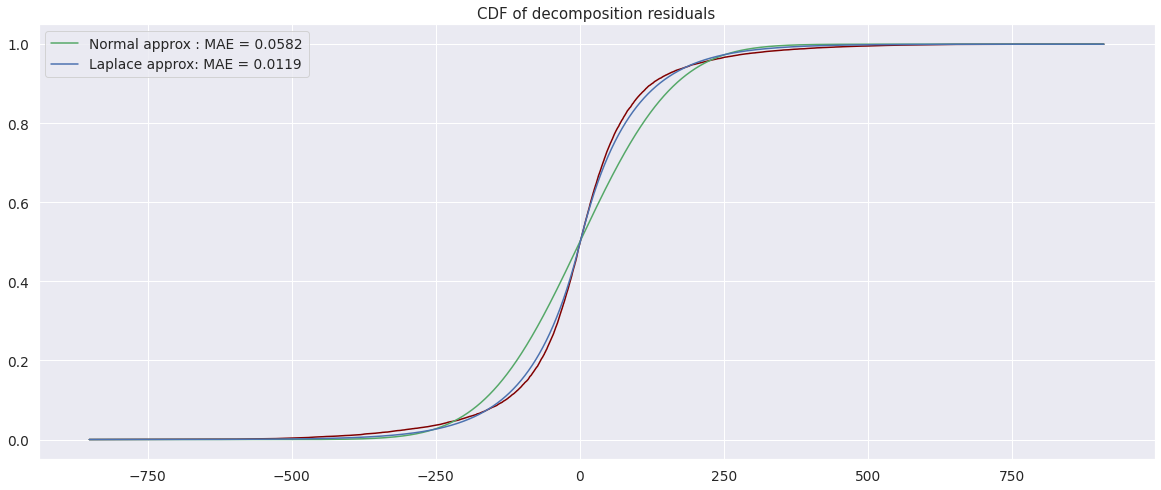

MAE_Gaussian/MAE_Laplace = 4.88.


In [ ]:
ecdf_resid_instance = ECDF(resid.dropna())
resid_arr = resid.dropna().sort_values().values
ecdf_resid = ecdf_resid_instance(resid_arr)


cdf_norm = st.norm.cdf(resid_arr, loc=loc_norm, scale=scale_norm)
cdf_laplace = st.laplace.cdf(resid_arr, loc=loc_laplace, scale=scale_laplace)


mae_norm = mean_absolute_error(ecdf_resid, cdf_norm)
mae_laplace = mean_absolute_error(ecdf_resid, cdf_laplace)


plt.subplots(1, 1, figsize=(20, 8))
plt.plot(resid_arr, ecdf_resid, '-', color='maroon')
plt.plot(resid_arr, cdf_norm, '-g',
         label=f"Normal approx : MAE = {mae_norm:.3g}")
plt.plot(resid_arr, cdf_laplace, '-b',
         label=f"Laplace approx: MAE = {mae_laplace:.3g}")
plt.legend()
plt.title("CDF of decomposition residuals")
plt.show()

print(f"MAE_Gaussian/MAE_Laplace = {mae_norm/mae_laplace:.3g}.")

Residuals have Laplace distribution.

## Correlation Analysis (of third difference)

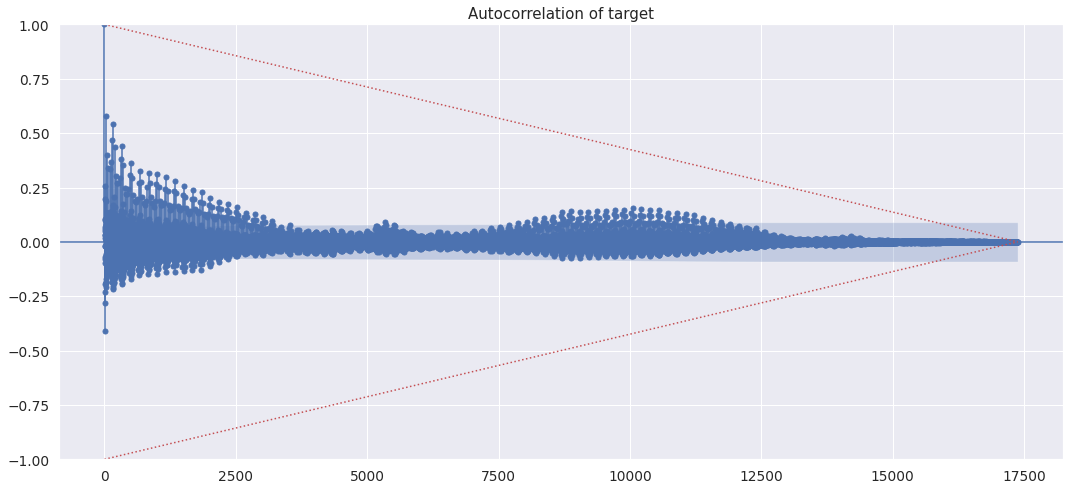

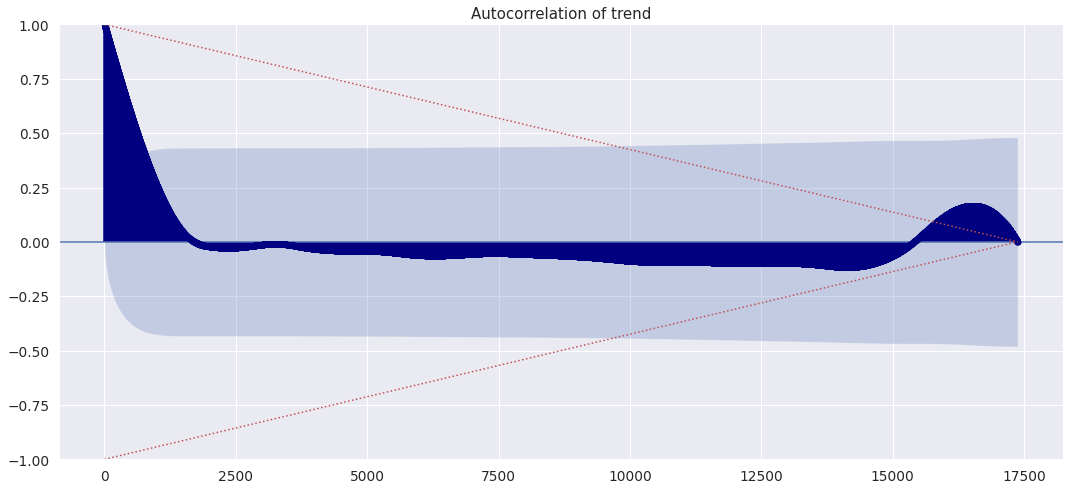

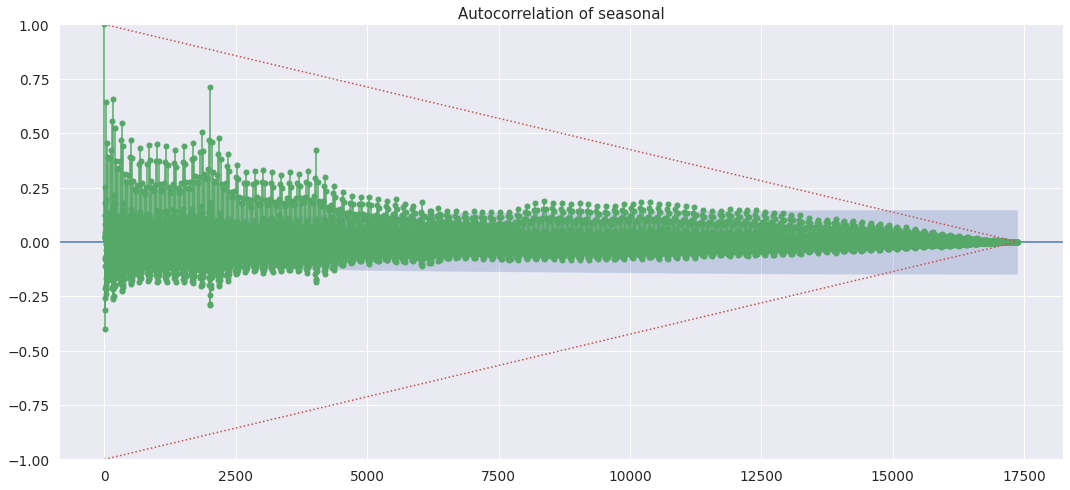

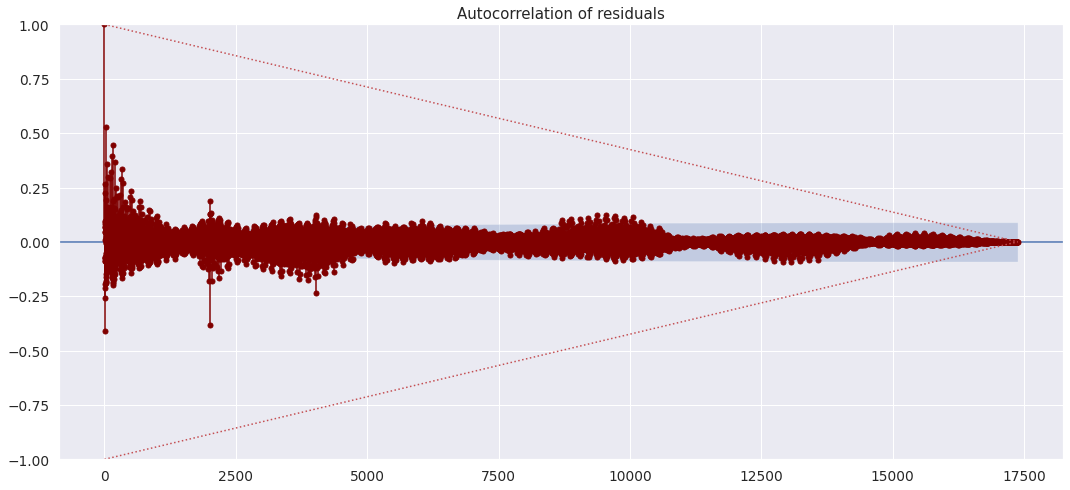

In [ ]:
N = len(y)
k = np.arange(0, N)
plot_acf(y,
         lags=N-1,
         vlines_kwargs={'color' : 'b'},
         markerfacecolor='b', markeredgecolor='b',
         title='Autocorrelation of target');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')

trend = decomposition.trend.dropna()
N = len(trend)
k = np.arange(0, N)
plot_acf(trend,
         lags=N-1,
         vlines_kwargs={'color' : 'navy'},
         markerfacecolor='navy', markeredgecolor='navy',
         title='Autocorrelation of trend');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


seasonal = decomposition.seasonal
N = len(seasonal)
k = np.arange(0, N)
plot_acf(seasonal,
         lags=N-1,
         vlines_kwargs={'color' : 'g'},
         markerfacecolor='g', markeredgecolor='g',
         title='Autocorrelation of seasonal');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


N = len(resid.dropna())
k = np.arange(0, N)
plot_acf(resid.dropna(),
         lags=N-1,
         vlines_kwargs={'color' : 'maroon'},
         markerfacecolor='maroon', markeredgecolor='maroon',
         title='Autocorrelation of residuals');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


plt.show()

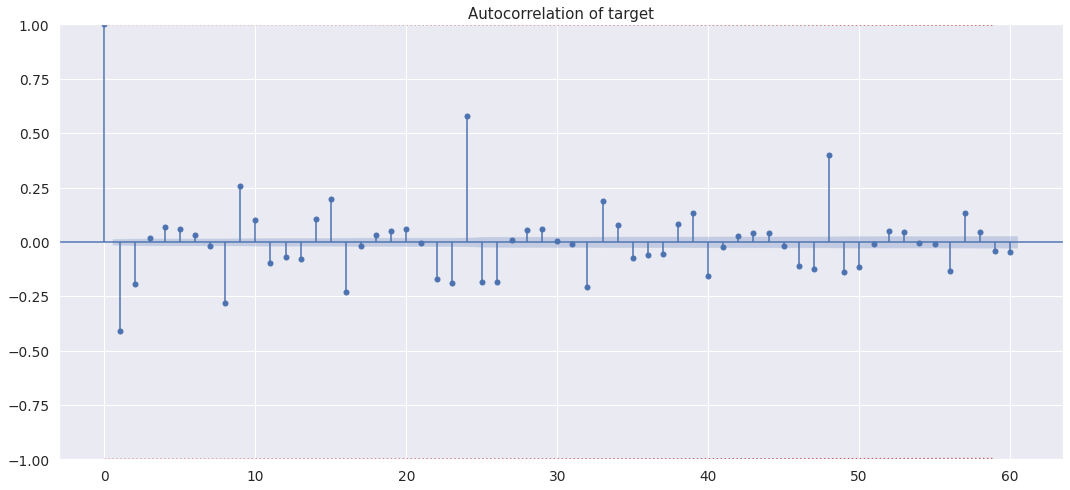

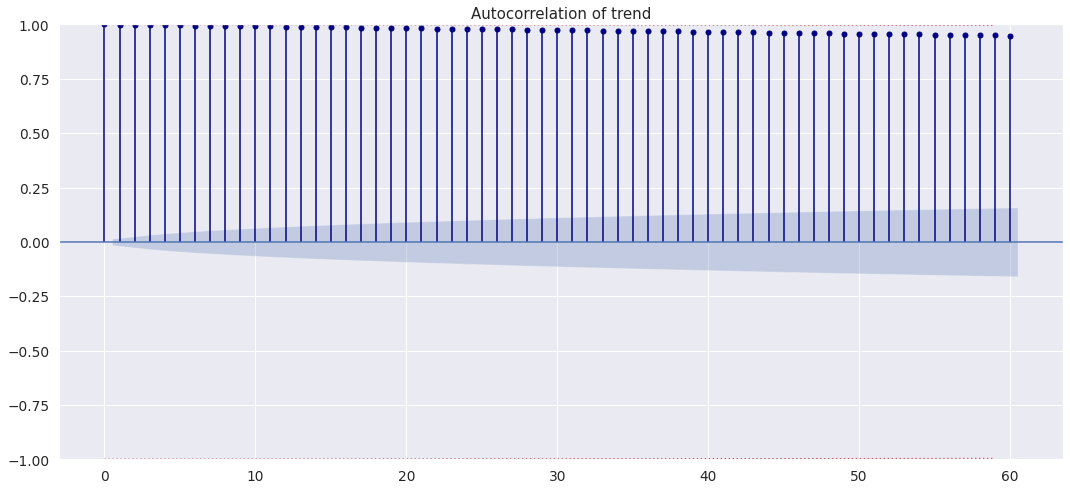

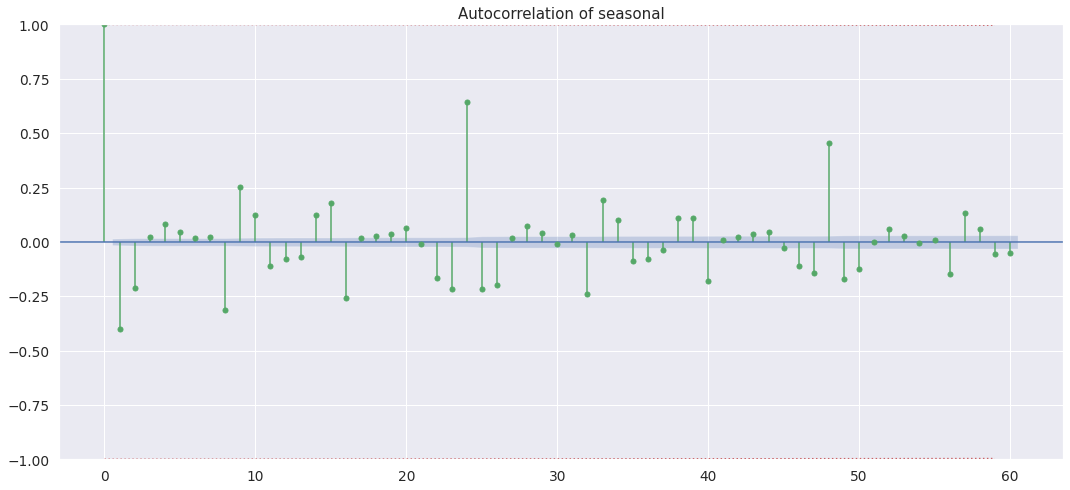

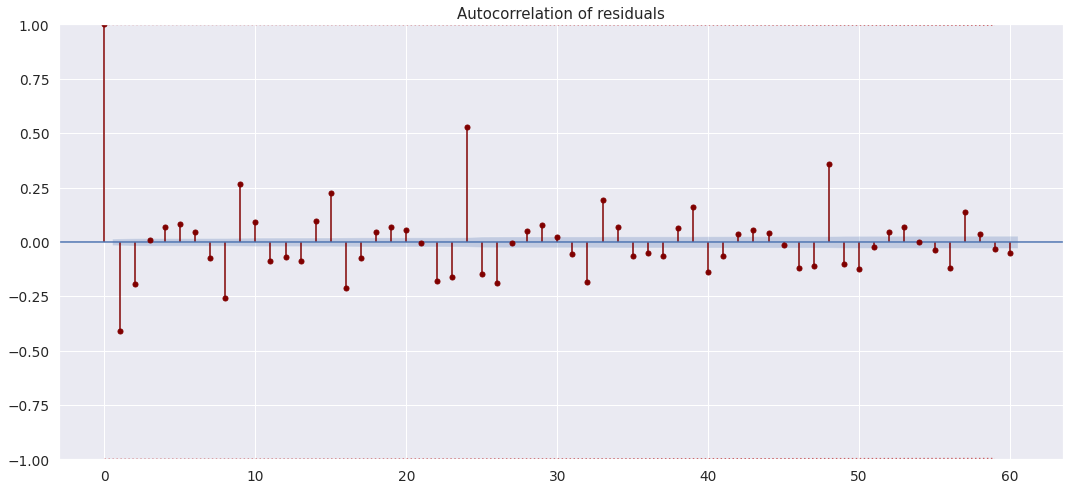

In [ ]:
lags = 60

N = len(y)
k = np.arange(0, lags)
plot_acf(y,
         lags=lags,
         vlines_kwargs={'color' : 'b'},
         markerfacecolor='b', markeredgecolor='b',
         title='Autocorrelation of target');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


N = len(trend)
plot_acf(trend,
         lags=lags,
         vlines_kwargs={'color' : 'navy'},
         markerfacecolor='navy', markeredgecolor='navy',
         title='Autocorrelation of trend');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


seasonal = decomposition.seasonal
N = len(seasonal)
plot_acf(seasonal,
         lags=lags,
         vlines_kwargs={'color' : 'g'},
         markerfacecolor='g', markeredgecolor='g',
         title='Autocorrelation of seasonal');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


N = len(resid.dropna())
plot_acf(resid.dropna(),
         lags=lags,
         vlines_kwargs={'color' : 'maroon'},
         markerfacecolor='maroon', markeredgecolor='maroon',
         title='Autocorrelation of residuals');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


plt.show()

Perform PACF to decide what lags should we use.

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


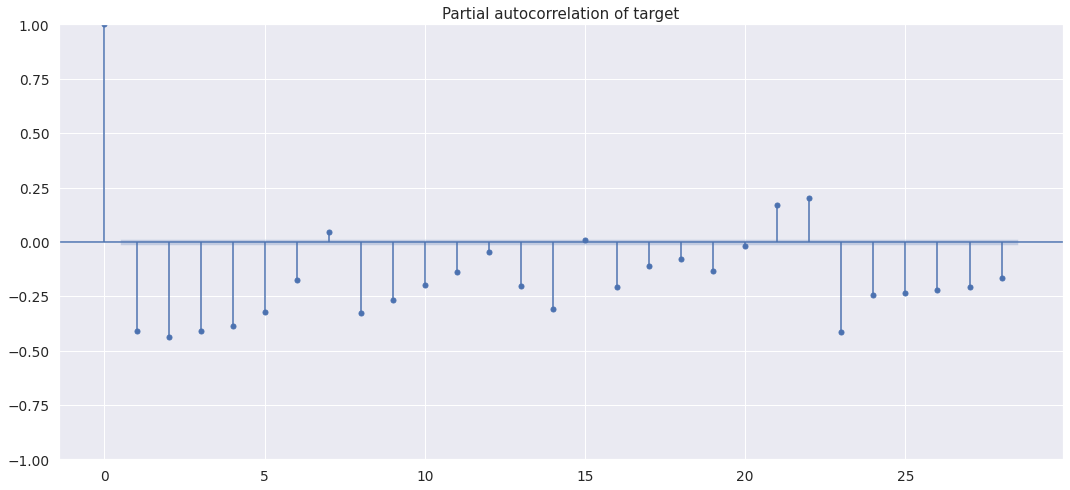

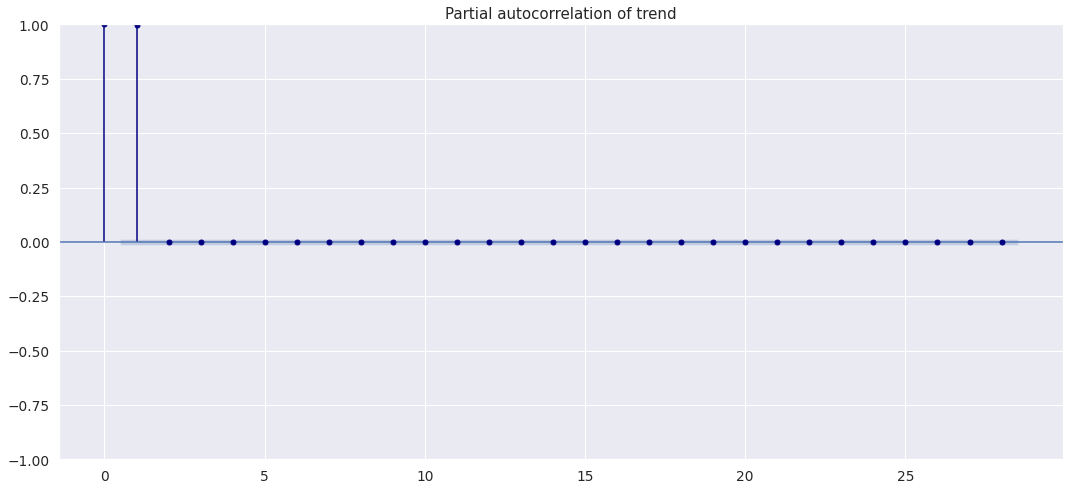

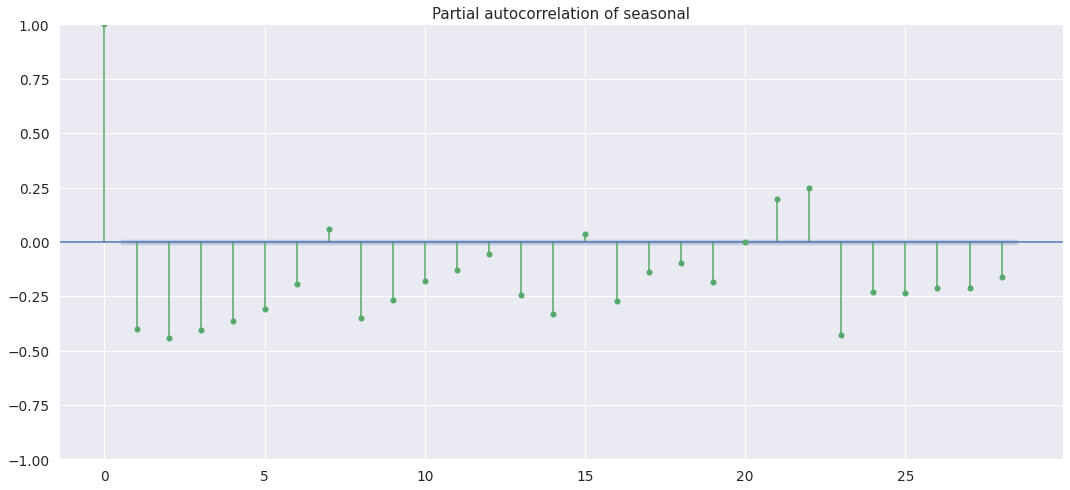

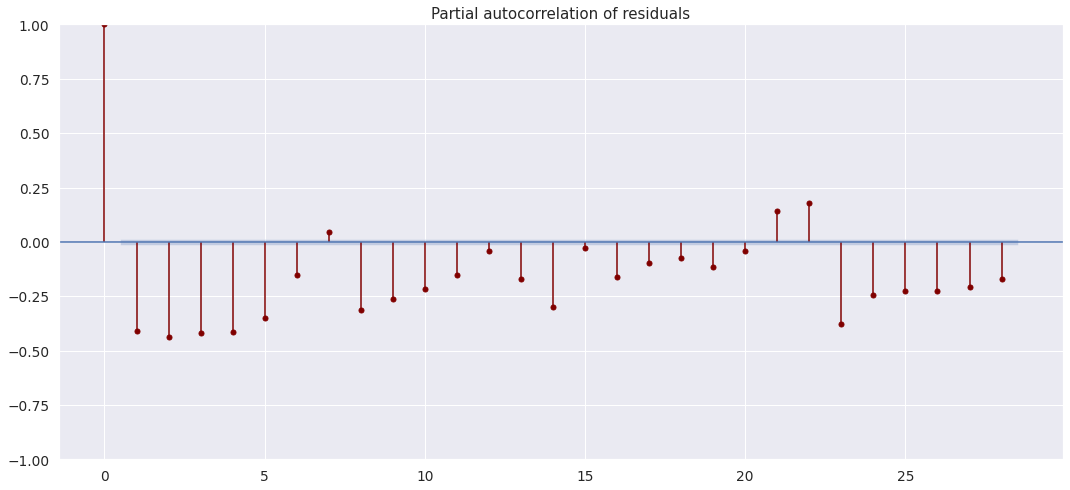

In [ ]:
lags = 28

plot_pacf(y,
         lags=lags,
         vlines_kwargs={'color' : 'b'},
         markerfacecolor='b', markeredgecolor='b',
         title='Partial autocorrelation of target');


plot_pacf(trend.dropna(),
         lags=lags,
         vlines_kwargs={'color' : 'navy'},
         markerfacecolor='navy', markeredgecolor='navy',
         title='Partial autocorrelation of trend');


seasonal = decomposition.seasonal
plot_pacf(seasonal,
         lags=lags,
         vlines_kwargs={'color' : 'g'},
         markerfacecolor='g', markeredgecolor='g',
         title='Partial autocorrelation of seasonal');


plot_pacf(resid.dropna(),
         lags=lags,
         vlines_kwargs={'color' : 'maroon'},
         markerfacecolor='maroon', markeredgecolor='maroon',
         title='Partial autocorrelation of residuals');


plt.show()

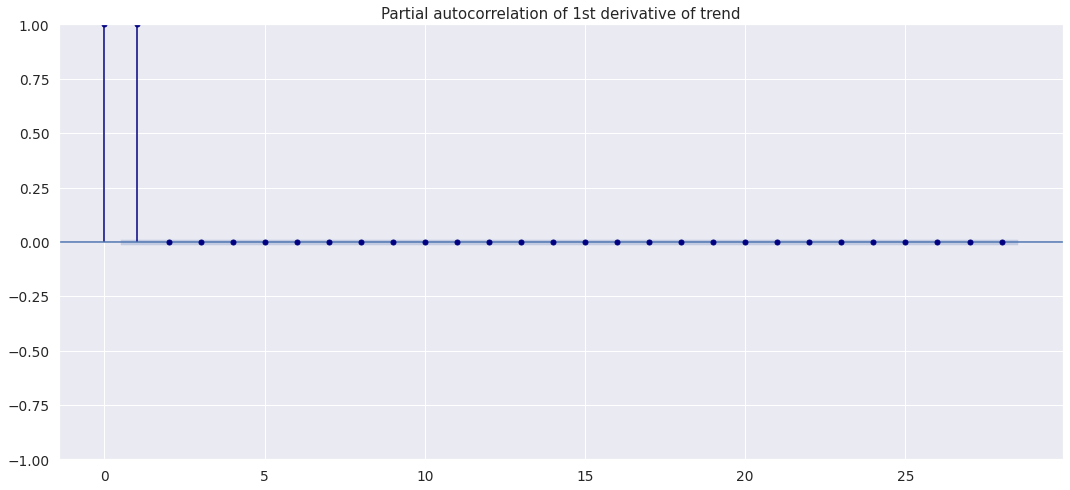

In [ ]:
plot_pacf(trend.dropna().diff().dropna(),
         lags=lags,
         vlines_kwargs={'color' : 'navy'},
         markerfacecolor='navy', markeredgecolor='navy',
         title='Partial autocorrelation of 1st derivative of trend');

## Train/Validation/Test Split

In [ ]:
# last month is a test set
N_test = 31
print(f"Total amount of points is {len(data)}, last {N_test} points are test points.")

train_ind = np.arange(len(data)-N_test)
test_ind = np.arange(len(data)-N_test, len(data))

train = data.iloc[train_ind, :]
test = data.iloc[test_ind, :]

Total amount of points is 17379, last 31 points are test points.


## Forecasting

### Naive approach (polynomial regression + seasonal component)

Let us obtain seasonal component as determenistic function and fit trend with polynomial (p=4) regression.

In [ ]:
stl = STL(train, period=24*7*12)
decomposition = stl.fit()

trend = decomposition.trend
seasonal = decomposition.seasonal

In [ ]:
def seasonal_component(ind, period=24):
    seasonal_unit = seasonal[:period].values
    ind_norm = ind % period

    return seasonal_unit[ind_norm]

[-7.98255486e-14  2.70674201e-09 -2.98280420e-05  1.27726353e-01
 -1.42298513e+01]


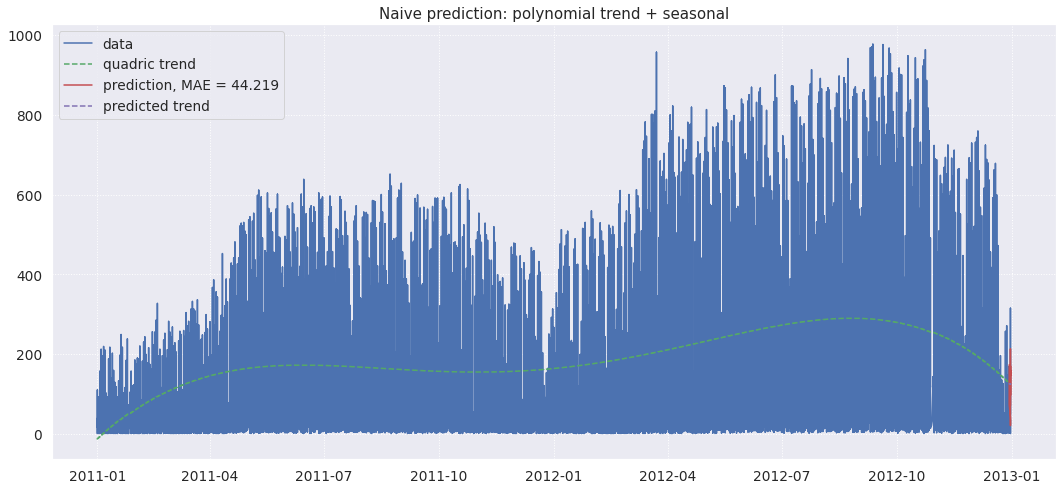

In [ ]:
X_train = trend.reset_index(drop=True).dropna()
X_train_ind = np.array(X_train.index)
y_train = X_train.values

poly_coeff = np.polyfit(X_train_ind, y_train, 4)
print(poly_coeff)
trend_pred = np.polyval(poly_coeff, test_ind)
pred = trend_pred + seasonal_component(test_ind)


trend_pred_train = np.polyval(poly_coeff, X_train_ind)

mae_naive = mean_absolute_error(test, pred)

plt.plot(data.index, data, '-b', label="data")
plt.plot(trend[X_train.index].index, trend_pred_train, '--g', label="quadric trend")

plt.plot(test.index, pred, '-r', label=f"prediction, MAE = {mae_naive:0.3f}")
plt.plot(test.index, trend_pred, '--m', label=f"predicted trend")
plt.grid(linestyle=':')
plt.legend()
plt.title("Naive prediction: polynomial trend + seasonal")
plt.show()

# ARIMA

In [ ]:
p, d, q = 24, 0, 24

arima_model = ARIMA(train, order=(p, d, q)).fit()
print()
print(f"ARIMA model ({p}, {d}, {q}):")
print(arima_model.params)

prediction_arima_train = arima_model.predict(train.index[0], train.index[-1])
prediction_arima_test = arima_model.predict(test_ind[0], test_ind[-1])

mae_arima = mean_absolute_error(y_true=test, y_pred=prediction_arima_test)

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



ARIMA model (24, 0, 24):
const      189.612285
ar.L1        1.079220
ar.L2       -0.888789
ar.L3        0.451090
ar.L4        0.021742
ar.L5       -0.183882
ar.L6        0.008950
ar.L7        0.448898
ar.L8       -0.853242
ar.L9        1.026122
ar.L10      -0.860994
ar.L11       0.426658
ar.L12      -0.030713
ar.L13      -0.168383
ar.L14      -0.041891
ar.L15       0.434644
ar.L16      -0.828734
ar.L17       0.990920
ar.L18      -0.808944
ar.L19       0.451910
ar.L20      -0.016679
ar.L21      -0.119291
ar.L22       0.004962
ar.L23       0.354100
ar.L24       0.066590
ma.L1       -0.053812
ma.L2        0.413403
ma.L3        0.103560
ma.L4       -0.098396
ma.L5        0.035472
ma.L6        0.057661
ma.L7       -0.484082
ma.L8        0.205512
ma.L9       -0.301624
ma.L10       0.259331
ma.L11       0.063772
ma.L12       0.034764
ma.L13       0.097808
ma.L14       0.284058
ma.L15      -0.134604
ma.L16       0.336679
ma.L17      -0.263073
ma.L18       0.138645
ma.L19      -0.123035
ma.L20

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


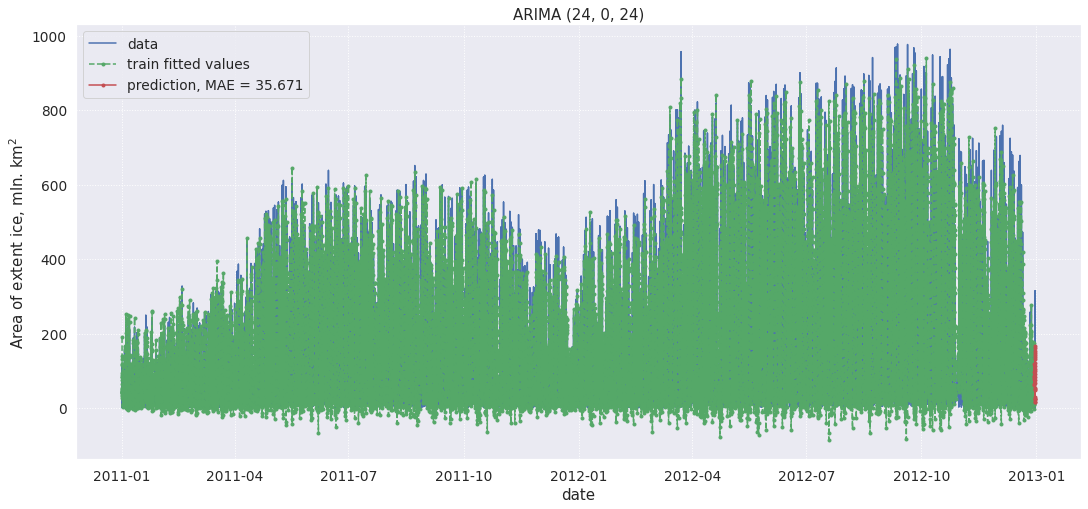

In [ ]:
plt.plot(data.index, data, '-b', label="data")
plt.plot(arima_model.fittedvalues, '--og', markersize=3,
         label="train fitted values")
plt.plot(test.index, prediction_arima_test, '-or', markersize=3,
         label=f"prediction, MAE = {mae_arima:0.3f}")
plt.grid(linestyle=':')
plt.legend()
plt.xlabel("date")
plt.ylabel("Area of extent ice, mln. km$^2$")
plt.title(f"ARIMA {(p, d, q)}")
plt.show(True)